In [67]:
#!pip install -q flax
from flax import linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
import seaborn as sns
import matplotlib.pyplot as plt
import neural_tangents as nt
from functools import partial
import numpy as np
import jax.numpy as jnp

/n/home08/bbordelon/.local/lib/python3.8/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [68]:
class CNN(nn.Module):
  """A simple CNN model"""
  width: int
    
  def setup(self):
    kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
    self.conv1 = nn.Conv(features = self.width, kernel_init = kif, use_bias = False, kernel_size = (3,3))
    self.conv2 = nn.Conv(features = self.width, kernel_init = kif, use_bias = False, kernel_size = (3,3))
    self.conv3 = nn.Conv(features = self.width, kernel_init = kif, use_bias = False, kernel_size = (3,3))
    self.conv4 = nn.Conv(features = self.width, kernel_init  = kif, use_bias = False, kernel_size = (3,3))
    self.conv5 = nn.Conv(features = self.width, kernel_init  = kif, use_bias = False, kernel_size = (3,3))
    self.readout = nn.Dense(features = 10, use_bias = True, kernel_init = kif)
    return

  def __call__(self, x, train = True):
    N = self.width
    D = 3
    x = self.conv1(x) / jnp.sqrt(D * 9)
    x = jnp.sqrt(2.0) * nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2,2), strides = (2,2)) # 32 x 32 -> 16 x 16
    x = self.conv2(x) / jnp.sqrt(N*9) # explicit N^{-1/2}
    x = jnp.sqrt(2.0) * nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2,2), strides = (2,2)) # 16 x 16 -> 8 x 8
    x = self.conv3(x)/jnp.sqrt(N*9)
    x = jnp.sqrt(2.0) * nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2,2), strides = (2,2)) # 8 x 8 -> 4 x 4
    x = self.conv4(x) / jnp.sqrt(N*9)
    x = jnp.sqrt(2.0) * nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2,2), strides = (2,2)) #  4 x 4 -> 2 x 2
    x = self.conv5(x) / jnp.sqrt(N*9)
    x = jnp.sqrt(2.0) * nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2,2), strides = (2,2)) #  2 x 2 -> 1 x 1
    x = x.reshape((x.shape[0], -1))  # flatten
    x = self.readout(x) / N # for mean field scaling
    return x

   


In [69]:
import jax
import jax.numpy as jnp  # JAX NumPy

N = 64
cnn = CNN(width = N)

N2 = 128
cnn2 = CNN(width=N2)
print(cnn.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 32, 32, 3))))
print(cnn2.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 32, 32, 3))))



                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,32,32,… │ float32[1,10]     │ conv1:            │
│         │        │                   │                   │   kernel:         │
│         │        │                   │                   │ float32[3,3,3,64] │
│         │        │                   │                   │ conv2:            │
│         │        │                   │                   │   kernel:         │
│         │        │                   │                   │ float32[3,3,64,6… │
│         │        │                   │                   │ conv3:            │
│         │        │                   │                   │   kernel:         │
│         │        │       

In [70]:
# check intermediates 


In [71]:
print(jax.local_device_count())
print(jax.devices()[0])

1
gpu:0


In [72]:
import tensorflow_datasets as tfds  # TFDS for imagenette
import tensorflow as tf             # TensorFlow operations

def get_datasets(num_epochs, batch_size, train_size = 50000):
  """Load MNIST train and test datasets into memory."""
  train_ds = tfds.load('cifar10', split=f'train[:{train_size}]')
  test_ds = tfds.load('cifar10', split='test')

  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                           tf.float32) / 255.,
                                          'label': sample['label']}) # normalize train set
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                         tf.float32) / 255.,
                                        'label': sample['label']}) # normalize test set

  train_ds = train_ds.repeat(num_epochs).shuffle(1024, reshuffle_each_iteration=False) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
  test_ds = test_ds.shuffle(1024, reshuffle_each_iteration=False) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return train_ds, test_ds

def get_full_data():
    
    (img_train, label_train), (img_test, label_test) = tfds.as_numpy(tfds.load(
        'cifar10',
        split=['train', 'test'],
        batch_size=-1,
        as_supervised=True,
    ))
    
    return img_train / 255.0 , label_train, img_test / 255.0, label_test


In [73]:

def create_train_state(module, rng, learning_rate, momentum, gamma):
  """Creates an initial `TrainState`."""
  params0 = module.init(rng, jnp.ones([1, 32, 32, 3]))['params'] # initialize parameters by passing a template image
  N = module.width
  tx = optax.sgd(learning_rate, momentum)
  shift_fn = jax.jit( lambda param_dict, x: (module.apply(param_dict, x) - module.apply({'params':params0},x)) / gamma )  # rescale by gamma
  return train_state.TrainState.create(
      apply_fn=shift_fn, params=params0, tx=tx)

In [74]:
@jax.jit
def train_step(state, Xb, yb):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, Xb)
    one_hot_label = nn.one_hot(yb, 10)
    one_hot_label -= 0.1*jnp.ones(one_hot_label.shape) # center the labels
    loss = optax.l2_loss(predictions = logits, targets = one_hot_label).mean() # MSE
    #loss = optax.softmax_cross_entropy_with_integer_labels(
    #    logits=logits, labels=yb).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def train_step_all(states, Xb, yb):
  """Train for a single step."""
  new_states = []
  for e, state in enumerate(states):
    def loss_fn(params):
      logits = state.apply_fn({'params': params}, Xb)
      one_hot_label = nn.one_hot(yb, 10)
      one_hot_label -= 0.1*jnp.ones(one_hot_label.shape) # center the labels
      loss = optax.l2_loss(predictions = logits, targets = one_hot_label).mean() 
      #loss = optax.softmax_cross_entropy_with_integer_labels(
      #    logits=logits, labels=yb).mean()
      return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    new_states += [ state.apply_gradients(grads=grads) ]
  #states = [ state.apply_gradients(grads=grad_fn(state.params)) for state in states] 
  return new_states

In [75]:
@jax.jit
def compute_metrics(*, state, Xb, yb):
  logits = state.apply_fn({'params': state.params}, Xb)
  #loss = optax.softmax_cross_entropy_with_integer_labels(
  #      logits=logits, labels=yb).mean()
  one_hot_label = nn.one_hot(yb,10)
  one_hot_label -= 0.1*jnp.ones(one_hot_label.shape)
  loss = optax.l2_loss(predictions = logits, targets = one_hot_label).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=yb, loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state, logits

@jax.jit
def compute_metrics_ens(*, mean_logits, Xb, yb, ens_metrics):
  
  #loss = optax.softmax_cross_entropy_with_integer_labels(logits=mean_logits, labels=yb).mean()
  one_hot_label = nn.one_hot(yb,10)
  one_hot_label -= 0.1*jnp.ones(one_hot_label.shape)
  loss = optax.l2_loss(predictions = mean_logits, targets = one_hot_label).mean()
  metric_updates = ens_metrics.single_from_model_output(logits=mean_logits, labels=yb, loss=loss)
  ens_metrics = ens_metrics.merge(metric_updates)
  return ens_metrics

@jax.jit
def get_all_metrics(states, Xb, yb):
  logits0 = states[0].apply_fn({'params': states[0].params}, Xb)
  mean_logits = jnp.zeros(logits0.shape, logits0.dtype)
  var_logits = jnp.zeros( logits0.shape, logits0.dtype )
  losses = []
  accs = []
  for e, state in enumerate(states):
    logits = state.apply_fn({'params': state.params}, Xb)
    #losses +=  [ optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=yb).mean() ]
    one_hot_label = nn.one_hot(yb,10)
    one_hot_label -= 0.1*jnp.ones(one_hot_label.shape)
    losses += [ optax.l2_loss(predictions = logits, targets = one_hot_label).mean() ]
    accs += [ jnp.mean(jnp.argmax(logits, -1) == yb)  ]
    mean_logits += 1.0/len(states) * logits
    var_logits += 1.0/len(states) * logits**2

  var_logits = jnp.mean( var_logits - mean_logits**2 ) / jnp.mean( mean_logits**2 ) 
  #ens_loss = optax.softmax_cross_entropy_with_integer_labels(
  #      logits=mean_logits, labels=yb).mean()
  one_hot_label = nn.one_hot(yb,10)
  one_hot_label -= 0.1*jnp.ones(one_hot_label.shape)
  ens_loss = optax.l2_loss(mean_logits, targets = one_hot_label).mean()
  ens_acc = jnp.mean(jnp.argmax(mean_logits, -1) == yb)
  return losses, ens_loss, accs, ens_acc, var_logits

@jax.jit
def get_all_metrics_single(state, Xb, yb):
  #mean_logits = jnp.zeros(logits0.shape, logits0.dtype)
  #var_logits = jnp.zeros( logits0.shape, logits0.dtype )
  #losses = []
  #accs = []
  #for e, state in enumerate(states):
  logits = state.apply_fn({'params': state.params}, Xb)
  #losses +=  [ optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=yb).mean() ]
  one_hot_label = nn.one_hot(yb,10)
  one_hot_label -= 0.1*jnp.ones(one_hot_label.shape)
  loss = optax.l2_loss(predictions = logits, targets = one_hot_label).mean() 
  accs =  jnp.mean(jnp.argmax(logits, -1) == yb)  
  return loss, accs, logits


@jax.jit
def get_all_metrics_with_kernels(states, Xb, yb):
  logits0 = states[0].apply_fn({'params': states[0].params}, Xb)
  mean_logits = jnp.zeros(logits0.shape, logits0.dtype )
  var_logits = jnp.zeros( logits0.shape, logits0.dtype )
  losses = []
  accs = [ ]
  for e, state in enumerate(states):
    logits = state.apply_fn({'params': state.params}, Xb)
    # use the sow call to get the intermediate features!
    losses +=  [ optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=yb).mean() ]
    #losses += [ optax.l2_loss(predictions = logits, targets = nn.one_hot(batch['label'],10)).mean() ]
    accs += [ jnp.mean(jnp.argmax(logits, -1) == yb)  ]
    mean_logits += 1.0/len(states) * logits
    var_logits += 1.0/len(states) * logits**2

  var_logits = jnp.mean( var_logits - mean_logits**2 ) / jnp.mean( mean_logits**2 ) 
  ens_loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=mean_logits, labels=yb).mean()
  #ens_loss = optax.l2_loss(mean_logits, targets = nn.one_hot(batch['label'],10)).mean()
  ens_acc = jnp.mean(jnp.argmax(mean_logits, -1) == yb)
  return losses, ens_loss, accs, ens_acc, var_logits

#@jax.jit
def get_alignment(states, feature_fn, Xbt, ybt):
    all_aligns = []
    y_hot = nn.one_hot(ybt, 10)
    y_hot -= 0.1 * jnp.ones(y_hot.shape)
    for e, state in enumerate(states):
        params = state.params
        #phi_H = feature_fn(params, Xbt)['conv5']['__call__'][0].mean(axis=(1,2))    
        phi_H = feature_fn(params, Xbt) # phi(H) over a batch
        K = jnp.einsum('ij,kj->ik', phi_H, phi_H) / phi_H.shape[1]
        
        
        proj = jnp.trace( y_hot.T @ K @ y_hot )
        
        #v = jnp.einsum('ij,ik->jk', phi_H, nn.one_hot(ybt , 10))  # N x 10
        all_aligns += [ proj / jnp.sqrt(jnp.sum(K**2)) / jnp.sqrt( jnp.sum( (y_hot.T @ y_hot)**2 ) ) ]
    return all_aligns

In [76]:
#batch_size = 512
#train_size = 50000
#num_epochs = 30

#train_ds, test_ds = get_datasets(num_epochs, batch_size, train_size)
X, y, X_test, y_test = get_full_data()

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [77]:
X = jnp.array(X)
y = jnp.array(y)
X_test = jnp.array(X_test)
y_test = jnp.array(y_test)
print(X.device())
print( y.device() )

gpu:0
gpu:0


In [79]:
params0 = cnn.init(jax.random.PRNGKey(0), jnp.ones([1, 32, 32, 3]))['params']
f1, state = cnn.apply({'params':params0}, X[:50], capture_intermediates=True, mutable=["intermediates"])
params0 = cnn2.init(jax.random.PRNGKey(0), jnp.ones([1, 32, 32, 3]))['params']
f2, state2 = cnn2.apply({'params':params0}, X[:50], capture_intermediates=True, mutable=["intermediates"])


In [80]:
print(state.keys())
print( state['intermediates'].keys() )
print( state['intermediates']['conv3']['__call__'][0].mean(axis=(1,2)).shape )
print( state['intermediates']['conv5']['__call__'][0].shape)

frozen_dict_keys(['intermediates'])
frozen_dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'readout', '__call__'])
(50, 64)
(50, 2, 2, 64)


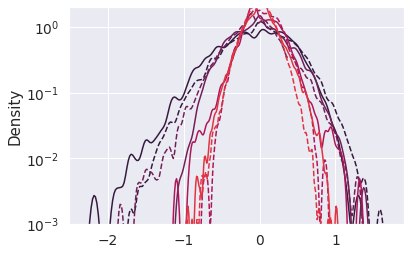

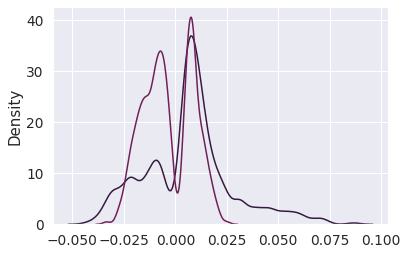

1.786667


In [81]:
bw = 0.5
sns.kdeplot( state['intermediates']['conv1']['__call__'][0].mean(axis=(1,2)).flatten() /jnp.sqrt(3.0*9) , bw_adjust = bw )
sns.kdeplot( state2['intermediates']['conv1']['__call__'][0].mean(axis=(1,2)).flatten()/jnp.sqrt(3.0*9) , linestyle = '--', color = 'C0', bw_adjust = bw )
sns.kdeplot( state['intermediates']['conv2']['__call__'][0].mean(axis=(1,2)).flatten() /jnp.sqrt(N * 9) , bw_adjust = bw )
sns.kdeplot( state2['intermediates']['conv2']['__call__'][0].mean(axis=(1,2)).flatten()/jnp.sqrt(N2 * 9), linestyle = '--' , color = 'C1', bw_adjust = bw )
sns.kdeplot( state['intermediates']['conv4']['__call__'][0].mean(axis=(1,2)).flatten() /jnp.sqrt(N * 9) , bw_adjust = bw )
sns.kdeplot( state2['intermediates']['conv4']['__call__'][0].mean(axis=(1,2)).flatten()/jnp.sqrt(N2 * 9), linestyle = '--', color = 'C2', bw_adjust = bw )
sns.kdeplot( state['intermediates']['conv5']['__call__'][0].flatten() /jnp.sqrt(N * 9) , bw_adjust = bw )
sns.kdeplot( state2['intermediates']['conv5']['__call__'][0].flatten()/jnp.sqrt(N2 * 9), linestyle = '--', color = 'C3', bw_adjust = bw )

#sns.kdeplot( state['intermediates']['readout']['__call__'][0].flatten() /jnp.sqrt(N * 16) )
#sns.kdeplot( state2['intermediates']['readout']['__call__'][0].flatten()/jnp.sqrt(N2 * 16), linestyle = '--',  color = 'C3')
plt.yscale('log')
plt.ylim([1e-3,2.0])
plt.show()

sns.kdeplot( f1.flatten()  , bw_adjust = bw )
sns.kdeplot( f2.flatten() , bw_adjust = bw )
plt.show()

print(jnp.sqrt(f1.var()) / jnp.sqrt(f2.var()))

In [83]:
# kernel fns 
def train_loaded(states, feature_fn, num_epochs=10, batch_size = 256, train_size = 50000):
  
  if train_size >= 50000:
    train_size = X.shape[0]
  
  num_steps_per_epoch = train_size // batch_size
  
  num_steps = num_epochs * num_steps_per_epoch 
  num_step_test = X_test.shape[0] // batch_size
  #num_steps_per_epoch = 10
  #num_steps = num_epochs * train_size // batch_size
  #num_steps_per_epoch = train_size // batch_size * 10
  #num_steps_per_epoch = 500
  #num_step_test = X_test.shape[0] // batch_size

  metrics_single = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'aligns': [], 'train_aligns': []}
  metrics_ens = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'train_logit_var': [], 'test_logit_var': [], 'aligns': [], 'train_aligns': []}

  epoch_single = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'aligns': [], 'train_aligns': []}
  epoch_ens = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'train_logit_var': [], 'test_logit_var': [], 'aligns': [], 'train_aligns': []}
  epoch_count = 0
  E = len(states)
  for step in range(num_steps):
    ind = (batch_size * step) % train_size
    Xb = X[ind:ind+batch_size] 
    yb = y[ind:ind+batch_size]
    #batch = {'image': Xb, 'label': yb}
    if ind == 0:
        epoch_count += 1
        #print("finished epoch %d " % epoch_count)
    
    
    if step == 0:
        print(yb[0:5])
    # compute train and ens train loss  
    losses, ens_loss, acc, ens_acc, var_logits = get_all_metrics(states, Xb, yb)
    aligns = get_alignment(states, feature_fn, Xb, yb)        

    epoch_single['train_loss'].append( jnp.array(losses).mean() )
    epoch_single['train_acc'].append( jnp.array(acc).mean()   )
    epoch_ens['train_loss'].append( ens_loss )
    epoch_ens['train_acc'].append( ens_acc )
    epoch_ens['train_logit_var'].append( var_logits )
    epoch_single['train_aligns'].append( aligns )
    epoch_ens['train_aligns'].append( jnp.array(aligns).mean() )

    for e, state in enumerate(states):
      # Run optimization steps over training batches and compute batch metrics
      states[e] = train_step(state, Xb, yb)
        

    if step % num_steps_per_epoch == 0: # one training epoch has passed    
      align = 0.0
      #print("computing test error")
      # Compute metrics on the test set after each training epoch
      for step_t in range(num_step_test):
        
        ind = (batch_size * step_t) % X_test.shape[0]
        Xbt = X_test[ind:ind+batch_size] 
        ybt = y_test[ind:ind+batch_size]
        if Xbt.shape[0] != batch_size:
            print("Xbt diff shape %d" % Xbt.shape[0])
        #test_batch = {'image': Xbt, 'label': ybt}
        losses, ens_loss, acc, ens_acc, var_logits = get_all_metrics(states, Xbt, ybt)
        #losses, ens_loss, acc, ens_acc, var_logits = get_all_metrics_with_kernels(states, test_batch)
        
        # y^T phi(H)^T phi(H) y
        aligns = get_alignment(states, feature_fn, Xbt, ybt)        
        epoch_single['test_loss'].append( jnp.array(losses).mean() )
        epoch_single['test_acc'].append( jnp.array(acc).mean()   )
        epoch_single['aligns'].append( aligns )
        
        epoch_ens['test_loss'].append( ens_loss )
        epoch_ens['test_acc'].append( ens_acc )
        epoch_ens['test_logit_var'].append( var_logits )
        epoch_ens['aligns'].append( jnp.array(aligns).mean() )
        
        
      # calculate average over all test batches
      for i, key in enumerate(metrics_single.keys()):
        metrics_single[key].append( jnp.array(epoch_single[key]).mean() )
        epoch_single[key] = []

      for i, key in enumerate(metrics_ens.keys()):
        metrics_ens[key].append( jnp.array(epoch_ens[key]).mean() )
        epoch_ens[key] = []

      print(f"step = {(step)//num_steps_per_epoch}, train = {metrics_single['train_loss'][-1]:0.3f}, test_loss = {metrics_single['test_loss'][-1]:0.3f}, ens_test = {metrics_ens['test_loss'][-1]:0.3f}, test_acc = {metrics_single['test_acc'][-1]:0.3f}, ens_test_acc = {metrics_ens['test_acc'][-1]:0.3f}, aligns = {metrics_ens['aligns'][-1]:0.3f}")
  return metrics_single, metrics_ens
    
def train_fn(states, num_epochs = 3):

  num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs // 2
  #num_steps_per_epoch = 256

  metrics_single = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
  metrics_ens = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'train_logit_var': [], 'test_logit_var': []}

  epoch_single = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
  epoch_ens = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'train_logit_var': [], 'test_logit_var': []}


  for step,batch in enumerate(train_ds.as_numpy_iterator()):
    
    if step == 0:
        print(batch['label'][0:5])
    # compute train and ens train loss  
    losses, ens_loss, acc, ens_acc, var_logits = get_all_metrics(states, batch)
    epoch_single['train_loss'].append( jnp.array(losses).mean() )
    epoch_single['train_acc'].append( jnp.array(acc).mean()   )
    epoch_ens['train_loss'].append( ens_loss )
    epoch_ens['train_acc'].append( ens_acc )
    epoch_ens['train_logit_var'].append( var_logits )

    states = train_step_all(states, batch)
    
    #for e, state in enumerate(states):
    #  # Run optimization steps over training batches and compute batch metrics
    #  states[e] = train_step(state, batch) # get updated train state (which contains the updated parameters)

  
    if step % num_steps_per_epoch == 0: # one training epoch has passed    
      
      # Compute metrics on the test set after each training epoch
      
      for i,test_batch in enumerate(test_ds.as_numpy_iterator()):
        
        losses, ens_loss, acc, ens_acc, var_logits = get_all_metrics(states, test_batch)
        epoch_single['test_loss'].append( jnp.array(losses).mean() )
        epoch_single['test_acc'].append( jnp.array(acc).mean()   )
        epoch_ens['test_loss'].append( ens_loss )
        epoch_ens['test_acc'].append( ens_acc )
        epoch_ens['test_logit_var'].append( var_logits )
            
        
      # calculate average over all test batches
      for i, key in enumerate(metrics_single.keys()):
        metrics_single[key].append( jnp.array(epoch_single[key]).mean() )
        epoch_single[key] = []

      for i, key in enumerate(metrics_ens.keys()):
        metrics_ens[key].append( jnp.array(epoch_ens[key]).mean() )
        epoch_ens[key] = []
            
      print(f"step = {(step)//num_steps_per_epoch}, train = {metrics_single['train_loss'][-1]:0.4f}, test_loss = {metrics_single['test_loss'][-1]:0.4f}, ens_test = {metrics_ens['test_loss'][-1]:0.4f}, test_acc = {metrics_single['test_acc'][-1]:0.4f}, ens_test_acc = {metrics_ens['test_acc'][-1]:0.4f}")
  return metrics_single, metrics_ens

## Sweep over widths $N$ at fixed $\gamma$

In [84]:
gamma_vals = [0.2]
#gamma_vals = [ 0.1, 0.2, 0.3 ]
#Nvals = [64, 128]
#Nvals = [32,64,128,256]
Nvals = [180]
tf.random.set_seed(0)
E = 8
init_rng_list = [ jax.random.PRNGKey(e) for e in range(E)]

base_lr = 10.0 
momentum = 0.0
batch_size = 256
#num_epochs = 125
num_epochs = 100
train_size = 50000

all_metrics_single = []
all_metrics_ens = []
keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_aligns']
keys_ens = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_logit_var', 'test_logit_var', 'train_aligns']

for i, gamma in enumerate(gamma_vals):  
    metrics_single_N = []
    metrics_ens_N = []
    for j, N in enumerate(Nvals):
        cnn = CNN(width = N)
        tf.random.set_seed(0)
        print(cnn.width)
        states = [ create_train_state(cnn, init_rng, cnn.width * gamma**(0.5) * base_lr, momentum, gamma = gamma) for init_rng in init_rng_list] # sweep over gamma
        feature_fn = jax.jit( lambda params,x: cnn.apply({'params':params}, x, capture_intermediates=True, mutable=["intermediates"])[1]['intermediates']['conv5']['__call__'][-1].mean(axis=(1,2)) / jnp.sqrt(N) )
        metrics_single, metrics_ens = train_loaded(states, feature_fn, num_epochs = num_epochs, batch_size = batch_size, train_size = train_size)
        metrics_single_N += [ metrics_single ]
        metrics_ens_N += [ metrics_ens ]
        
        for key in keys:
            path = f'results/{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch_size}_train_size_{train_size}_mse.npy'
            np.save(path, jnp.array(metrics_single[key]))
        for key in keys_ens:
            ens_path = f'results/ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch_size}_train_size_{train_size}_mse.npy'
            np.save(ens_path, jnp.array(metrics_ens[key]))
            
    all_metrics_single += [metrics_single_N]
    all_metrics_ens += [metrics_ens_N]
    

180
[7 8 4 4 6]
step = 0, train = 0.045, test_loss = 0.046, ens_test = 0.046, test_acc = 0.115, ens_test_acc = 0.122, aligns = 0.014
step = 1, train = 0.043, test_loss = 0.043, ens_test = 0.043, test_acc = 0.228, ens_test_acc = 0.230, aligns = 0.039
step = 2, train = 0.041, test_loss = 0.042, ens_test = 0.042, test_acc = 0.278, ens_test_acc = 0.280, aligns = 0.054
step = 3, train = 0.040, test_loss = 0.039, ens_test = 0.039, test_acc = 0.356, ens_test_acc = 0.367, aligns = 0.073
step = 4, train = 0.039, test_loss = 0.039, ens_test = 0.038, test_acc = 0.368, ens_test_acc = 0.372, aligns = 0.081
step = 5, train = 0.038, test_loss = 0.038, ens_test = 0.038, test_acc = 0.382, ens_test_acc = 0.387, aligns = 0.080
step = 6, train = 0.037, test_loss = 0.037, ens_test = 0.036, test_acc = 0.412, ens_test_acc = 0.421, aligns = 0.097
step = 7, train = 0.037, test_loss = 0.037, ens_test = 0.036, test_acc = 0.409, ens_test_acc = 0.416, aligns = 0.094
step = 8, train = 0.036, test_loss = 0.036, ens_

In [98]:
### N sweep plots use these parameters
import numpy as np
import matplotlib.pyplot as plt
gamma_vals = [0.2]
#gamma_vals = [0.1]
#Nvals = [128, 25Nvals = [64, 128]
Nvals = [32, 45, 64, 90, 128, 256]
E = 8
batch = 256
train_size = 50000
loss_used = '_mse'
keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_aligns']
ens_keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_logit_var', 'test_logit_var', 'train_aligns']


read_single =  [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
read_ens  = [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
for i, gamma in enumerate(gamma_vals):
    for j, N in enumerate(Nvals):
        #dict_ij = all_metrics_single[i][j]
        for key in keys:
            #print(jnp.array(dict_ij[key]))
            path = f'results/{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}' + loss_used + '.npy'
            #os.mkdir(path)
            read_single[i][j][key] = np.load(path)
        for key in ens_keys:
            path = f'results/ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}'+ loss_used + '.npy'
            #os.mkdir(path)
            read_ens[i][j][key] = np.load(path)

-0.008360252059573485
-0.00903141764034087
-0.010190070809973733
-0.01091014338500948
-0.012562661605768778
-0.015243491688302264


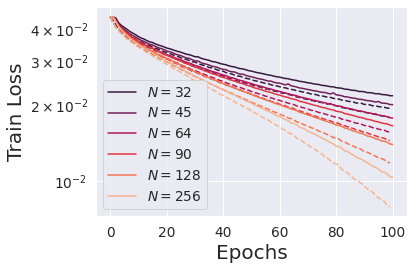

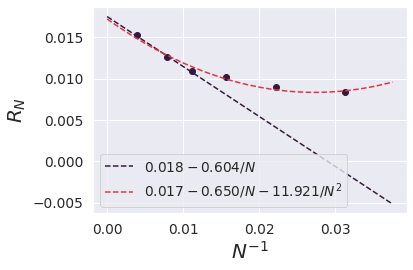

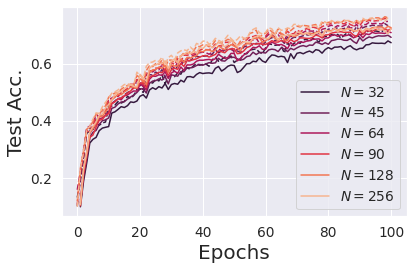

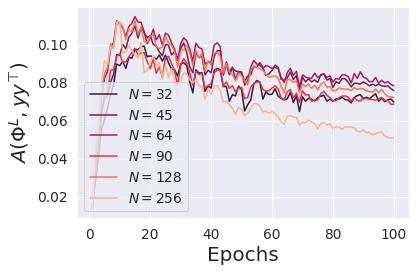

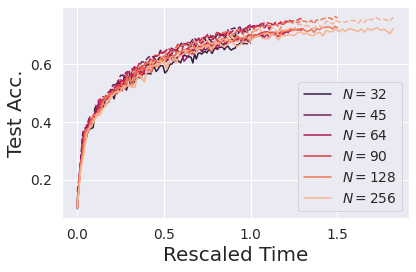

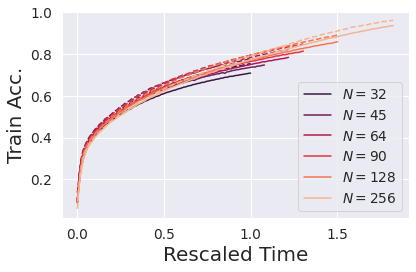

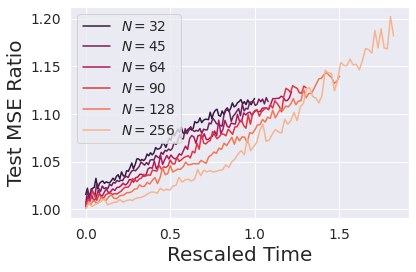

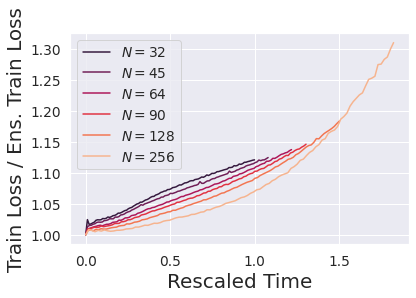

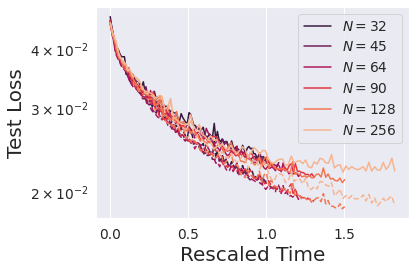

In [99]:
import seaborn as sns
sns.set(font_scale=1.25)
sns.set_style("darkgrid")
sns.set_palette("rocket")

exponents = []
for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        length = len(read_single[i][j]['train_loss'])
        plt.plot(np.linspace(1,length, length) , np.array( read_single[i][j]['train_loss']), color = f'C{j}',label = f'$N = {N}$')
        plt.plot( read_ens[i][j]['train_loss'],  '--', color = f'C{j}')
        
        t = np.linspace(1,int(0.8*length), int(0.8*length))
        logloss = np.log(read_ens[i][j]['train_loss'][:len(t)])
        exponent = (np.mean(t * logloss) - np.mean(t)*np.mean(logloss)) / np.var(t)
        print(exponent)
        exponents += [exponent]
    if j ==0:
        plt.ylabel(r'Train Loss',fontsize =20)
    
plt.xlabel(r'Epochs',fontsize = 20)
plt.yscale('log')
#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_N_trainMSE_no_xaxis_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()



Ninv = np.array(Nvals)**(-1.0)
Xl = np.zeros((3,len(Nvals)))
Xl[0,:] = np.ones(len(Nvals))
Xl[1,:] = Ninv
Xl[2,:] = Ninv**2
yl = - np.array(exponents)
 
coeffs = np.linalg.solve(Xl @ Xl.T, Xl @ yl)
#exp_exp = (np.mean(Ninv * yl) - np.mean(Ninv)*np.mean(yl) )/np.var(Ninv)
#exp_b = np.mean(yl) - np.mean(Ninv) * exp_exp
Ninv_dense = np.linspace(0.0, 1.2/np.amin(Nvals))
Xl_dense = np.zeros((3,len(Ninv_dense)))
Xl_dense[0,:] = np.ones(len(Ninv_dense))
Xl_dense[1,:] = Ninv_dense
Xl_dense[2,:] = Ninv_dense**2

Xl_lin= Xl[0:2,3:]
coeffs_lin = np.linalg.solve(Xl_lin @ Xl_lin.T, Xl_lin @ yl[3:])

plt.plot(Ninv_dense, Xl_dense[0:2,:].T @ coeffs_lin, '--', color = 'C0', label= f'${coeffs_lin[0]:0.3f} {coeffs_lin[1]:0.3f}/N$') 
plt.plot(Ninv_dense, Xl_dense.T @ coeffs, '--', color = 'C3', label= f'${coeffs[0]:0.3f} {coeffs[1]:0.3f}/N - {coeffs[2]:0.3f}/N^2$') 
plt.scatter(Ninv, yl)
plt.xlabel(r'$N^{-1}$',fontsize = 20)
plt.ylabel(r'$R_N$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_rescale_exponentsvsN_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()

for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        length = len(read_single[i][j]['test_acc'])
        plt.plot(np.linspace(1,length, length) , np.array( read_single[i][j]['test_acc']), color = f'C{j}',label = f'$N = {N}$')
        plt.plot( read_ens[i][j]['test_acc'],  '--', color = f'C{j}')
        
    if j ==0:
        plt.ylabel(r'Test Acc.',fontsize =20)    
plt.xlabel(r'Epochs',fontsize = 20)
#plt.yscale('log')
#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_N_testacc_no_xaxis_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()


plt.rcParams.update({'font.size': 14})
for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        length = len(read_single[i][j]['test_acc'])

        #plt.plot(  np.linspace(0,1, length)* exponents[j] / exponents[0] ,  read_ens[i][j]['aligns'], color = f'C{j}',label = f'$N = {N}$')
        plt.plot(  np.linspace(1,length, length),  read_ens[i][j]['aligns'], color = f'C{j}',label = f'$N = {N}$')

    if j ==0:
        plt.ylabel(r'$A(\Phi^L, y y^{\top})$',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_N_aligns_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()

for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        length = len(read_single[i][j]['test_acc'])

        plt.plot(  np.linspace(0,1, length)* exponents[j] / exponents[0],  read_single[i][j]['test_acc'], color = f'C{j}',label = f'$N = {N}$')
        plt.plot( np.linspace(0,1, length)* exponents[j] / exponents[0], read_ens[i][j]['test_acc'],  '--', color = f'C{j}')
    if j ==0:
        plt.ylabel(r'Test Acc.',fontsize =20)
plt.xlabel(r'Rescaled Time',fontsize = 20)

#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_N_test_accs_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()


for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        length = len(read_single[i][j]['train_acc'])

        plt.plot( np.linspace(0,1, length)* exponents[j] / exponents[0], read_single[i][j]['train_acc'], color = f'C{j}',label = f'$N = {N}$')
        plt.plot( np.linspace(0,1, length)* exponents[j] / exponents[0] , read_ens[i][j]['train_acc'],  '--', color = f'C{j}')
    if j ==0:
        plt.ylabel(r'Train Acc.',fontsize =20)
plt.xlabel(r'Rescaled Time',fontsize = 20)

#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_N_train_accs_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()


for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        length = len(read_single[i][j]['test_loss'])
        plt.plot(np.linspace(0,1, length)* exponents[j] / exponents[0] , np.array( read_single[i][j]['test_loss'])/np.array(read_ens[i][j]['test_loss']), color = f'C{j}',label = f'$N = {N}$')
        #plt.plot( read_ens[i][j]['train_acc'],  '--', color = f'C{j}')
    if j ==0:
        plt.ylabel(r'Test MSE Ratio',fontsize =20)
plt.xlabel(r'Rescaled Time',fontsize = 20)

#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_N_testMSE_ratio_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()


for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        length = len(read_single[i][j]['train_loss'])
        plt.plot(np.linspace(0,1, length)* exponents[j] / exponents[0] , np.array( read_single[i][j]['train_loss'])/np.array(read_ens[i][j]['train_loss']), color = f'C{j}',label = f'$N = {N}$')
        #plt.plot( read_ens[i][j]['train_acc'],  '--', color = f'C{j}')
    if j ==0:
        plt.ylabel(r'Train Loss / Ens. Train Loss',fontsize =20)
plt.xlabel(r'Rescaled Time',fontsize = 20)

#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_N_trainMSE_ratio_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()


for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        length = len(read_single[i][j]['test_loss'])
        plt.plot( np.linspace(0,1, length)* exponents[j] / exponents[0], np.array( read_single[i][j]['test_loss']), color = f'C{j}',label = f'$N = {N}$')
        plt.plot( np.linspace(0,1, length)* exponents[j] / exponents[0], read_ens[i][j]['test_loss'],  '--', color = f'C{j}')
    if j ==0:
        plt.ylabel(r'Test Loss',fontsize =20)
plt.xlabel(r'Rescaled Time',fontsize = 20)

#plt.title(f'$N={N}$',fontsize = 20)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_N_testMSE_no_xaxis_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()


In [ ]:
import seaborn as sns
palette = sns.color_palette("mako_r", 6)
plt.figure()

data = [read_ens[0][j]['train_loss'] for j, N in enumerate(Nvals)]
sns.lineplot(
    data=data, x="time", y="firing_rate",
    hue="coherence", style="choice",
    palette=palette
)
plt.show((

[0.04603174 0.04351702 0.04228944 0.04002158]


## Now consider $\gamma$ sweep at fixed $N$

## Try different Learning rate $\eta(N)$ scalings

In [7]:
# compare scaling of learning rate with N
gamma_vals = [0.2]
#Nvals = [128, 25Nvals = [64, 128]
Nvals = [128]
batch = 256
train_size = 50000

E = 2

#loss_used = ''
loss_used = '_mse'
ens_keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_logit_var', 'test_logit_var', 'train_aligns']
keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_aligns']

read_single_lin =  [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
read_ens_lin = [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
for i, gamma in enumerate(gamma_vals):
    for j, N in enumerate(Nvals):
        #dict_ij = all_metrics_single[i][j]
        for key in keys:
            #print(jnp.array(dict_ij[key]))
            path = f'results/{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}_linearN' + loss_used + '.npy'
            #os.mkdir(path)
            read_single_lin[i][j][key] = np.load(path)
        for key in ens_keys:
            path = f'results/ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}_linearN'+ loss_used + '.npy'
            #os.mkdir(path)
            read_ens_lin[i][j][key] = np.load(path)


read_single_sqrt =  [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
read_ens_sqrt = [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
for i, gamma in enumerate(gamma_vals):
    for j, N in enumerate(Nvals):
        #dict_ij = all_metrics_single[i][j]
        for key in keys:
            #print(jnp.array(dict_ij[key]))
            path = f'results/{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}_sqrt' + loss_used + '.npy'
            #os.mkdir(path)
            read_single_sqrt[i][j][key] = np.load(path)
        for key in ens_keys:
            path = f'results/ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}_sqrt'+ loss_used + '.npy'
            #os.mkdir(path)
            read_ens_sqrt[i][j][key] = np.load(path)

            

read_single =  [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
read_ens  = [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
for i, gamma in enumerate(gamma_vals):
    for j, N in enumerate(Nvals):
        #dict_ij = all_metrics_single[i][j]
        for key in keys:
            #print(jnp.array(dict_ij[key]))
            path = f'results/{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}' + loss_used + '.npy'
            #os.mkdir(path)
            read_single[i][j][key] = np.load(path)
        for key in ens_keys:
            path = f'results/ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}'+ loss_used + '.npy'
            #os.mkdir(path)
            read_ens[i][j][key] = np.load(path)

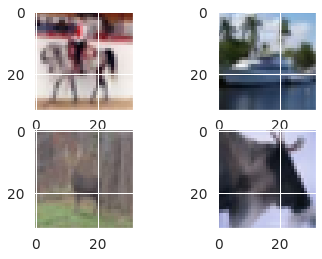

In [109]:
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X[i])
plt.show()

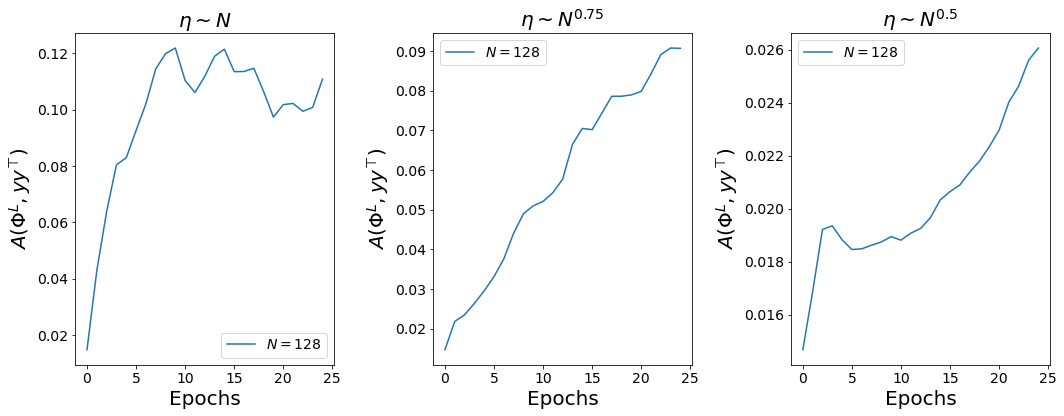

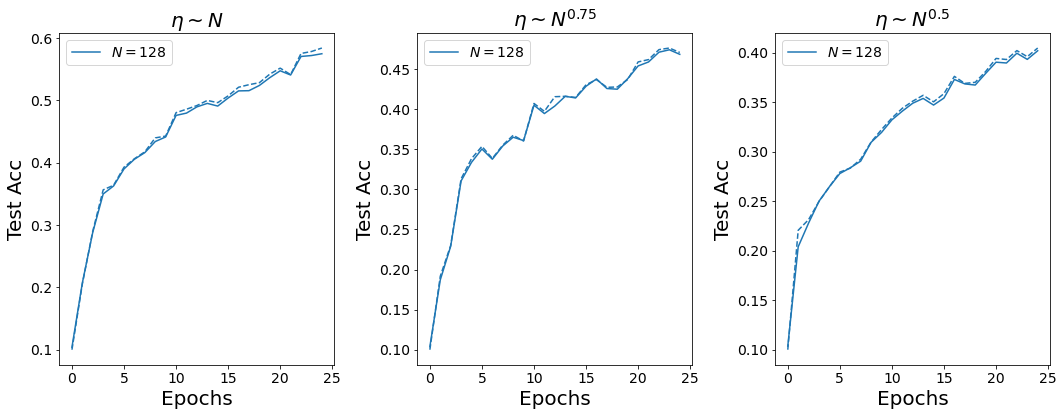

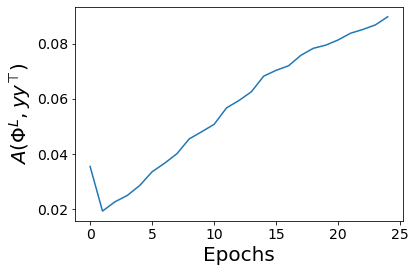

In [8]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize = (15, 6))
plt.subplot(1,3,1)
for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_ens_lin[i][j]['aligns'], color = f'C{j}',label = f'$N = {N}$')
    if j ==0:
        plt.ylabel(r'$A(\Phi^L, y y^{\top})$',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.title('$\eta \sim N$',fontsize = 20)
plt.tight_layout()
plt.subplot(1,3,2)
for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_ens[i][j]['aligns'], color = f'C{j}',label = f'$N = {N}$')
    if j ==0:
        plt.ylabel(r'$A(\Phi^L, y y^{\top})$',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
plt.title('$\eta \sim N^{0.75}$',fontsize = 20)

#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()

plt.subplot(1,3,3)
for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_ens_sqrt[i][j]['aligns'], color = f'C{j}',label = f'$N = {N}$')
    if j ==0:
        plt.ylabel(r'$A(\Phi^L, y y^{\top})$',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
plt.title('$\eta \sim N^{0.5}$',fontsize = 20)
#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show() 

plt.figure(figsize = (15, 6))
plt.subplot(1,3,1)
for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_single_lin[i][j]['test_acc'], color = f'C{j}',label = f'$N = {N}$')
        plt.plot(  read_ens_lin[i][j]['test_acc'],'--', color = f'C{j}')
    if j ==0:
        plt.ylabel(r'Test Acc',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
plt.title('$\eta \sim N$',fontsize = 20)

#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.subplot(1,3,2)

for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_single[i][j]['test_acc'], color = f'C{j}',label = f'$N = {N}$')
        plt.plot(  read_ens[i][j]['test_acc'],'--', color = f'C{j}')
    if j ==0:
        plt.ylabel(r'Test Acc',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
plt.title('$\eta \sim N^{0.75}$',fontsize = 20)

#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.subplot(1,3,3)

for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_single_sqrt[i][j]['test_acc'], color = f'C{j}',label = f'$N = {N}$')
        plt.plot(  read_ens_sqrt[i][j]['test_acc'],'--', color = f'C{j}')
    if j ==0:
        plt.ylabel(r'Test Acc',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
plt.title('$\eta \sim N^{0.5}$',fontsize = 20)

#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show() 

for j, N in enumerate(Nvals):
    #plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_ens[i][j]['train_aligns'], color = f'C{j}', label = f'N = {N}')
    if j ==0:
        #plt.legend()
        plt.ylabel(r'$A(\Phi^L, y y^{\top})$',fontsize =20)
    plt.xlabel(r'Epochs',fontsize = 20)
    #plt.title(f'$N={N}$',fontsize = 20)
    plt.tight_layout()
plt.show()  

## Try $\gamma$ sweep with two different $N$ values

In [111]:
#gamma_vals = [ 0.1, 0.2, 0.3 ]
gamma_vals = [0.035]
Nvals = [64]
tf.random.set_seed(0)
E = 10
init_rng_list = [ jax.random.PRNGKey(e) for e in range(E)]

base_lr = 5.0 
momentum = 0.0
batch_size = 256
#num_epochs = 125
num_epochs = 250
train_size = 50000

all_metrics_single = []
all_metrics_ens = []
keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_aligns']
keys_ens = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_logit_var', 'test_logit_var', 'train_aligns']

for i, gamma in enumerate(gamma_vals):  
    metrics_single_N = []
    metrics_ens_N = []
    for j, N in enumerate(Nvals):
        cnn = CNN(width = N)
        tf.random.set_seed(0)
        print(cnn.width)
        states = [ create_train_state(cnn, init_rng, cnn.width**(0.75) * gamma**(0.5) * base_lr, momentum, gamma = gamma) for init_rng in init_rng_list] # sweep over gamma
        feature_fn = jax.jit( lambda params,x: cnn.apply({'params':params}, x, capture_intermediates=True, mutable=["intermediates"])[1]['intermediates']['conv5']['__call__'][-1].mean(axis=(1,2)) / jnp.sqrt(N) )
        metrics_single, metrics_ens = train_loaded(states, feature_fn, num_epochs = num_epochs, batch_size = batch_size, train_size = train_size)
        metrics_single_N += [ metrics_single ]
        metrics_ens_N += [ metrics_ens ]
        
        for key in keys:
            path = f'results/{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch_size}_train_size_{train_size}_mse.npy'
            np.save(path, jnp.array(metrics_single[key]))
        for key in keys_ens:
            ens_path = f'results/ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch_size}_train_size_{train_size}_mse.npy'
            np.save(ens_path, jnp.array(metrics_ens[key]))
            
    all_metrics_single += [metrics_single_N]
    all_metrics_ens += [metrics_ens_N]
    

64
[7 8 4 4 6]
step = 0, train = 0.045, test_loss = 0.052, ens_test = 0.048, test_acc = 0.120, ens_test_acc = 0.111, aligns = 0.014
step = 1, train = 0.054, test_loss = 0.059, ens_test = 0.044, test_acc = 0.179, ens_test_acc = 0.202, aligns = 0.017
step = 2, train = 0.048, test_loss = 0.046, ens_test = 0.042, test_acc = 0.223, ens_test_acc = 0.268, aligns = 0.018
step = 3, train = 0.046, test_loss = 0.048, ens_test = 0.041, test_acc = 0.295, ens_test_acc = 0.344, aligns = 0.018
step = 4, train = 0.045, test_loss = 0.043, ens_test = 0.040, test_acc = 0.307, ens_test_acc = 0.362, aligns = 0.019
step = 5, train = 0.044, test_loss = 0.045, ens_test = 0.041, test_acc = 0.316, ens_test_acc = 0.324, aligns = 0.019
step = 6, train = 0.043, test_loss = 0.042, ens_test = 0.039, test_acc = 0.328, ens_test_acc = 0.371, aligns = 0.020
step = 7, train = 0.043, test_loss = 0.041, ens_test = 0.039, test_acc = 0.331, ens_test_acc = 0.365, aligns = 0.021
step = 8, train = 0.042, test_loss = 0.046, ens_t

In [1]:
import numpy as np
import matplotlib.pyplot as plt

gamma_vals = [0.035,0.05, 0.1, 0.2, 0.3]
Nvals = [64]

batch = 256
train_size = 50000
E = 10

#loss_used = ''
loss_used = '_mse'
ens_keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns','train_aligns', 'train_logit_var', 'test_logit_var']
keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_aligns']

read_single =  [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
read_ens = [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
for i, gamma in enumerate(gamma_vals):
    for j, N in enumerate(Nvals):
        #dict_ij = all_metrics_single[i][j]
        for key in keys:
            #print(jnp.array(dict_ij[key]))
            path = f'results/{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}' + loss_used + '.npy'
            #os.mkdir(path)
            read_single[i][j][key] = np.load(path)
        for key in ens_keys:
            path = f'results/ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}'+ loss_used + '.npy'
            #os.mkdir(path)
            read_ens[i][j][key] = np.load(path)

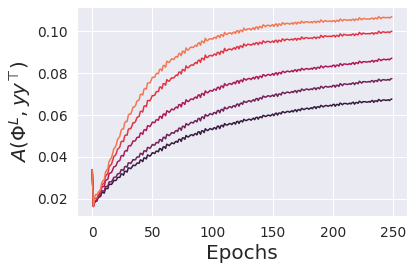

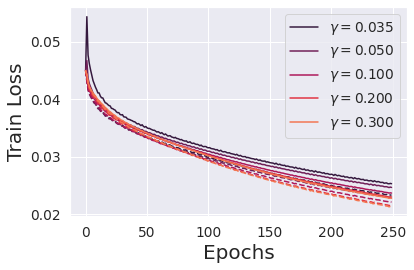

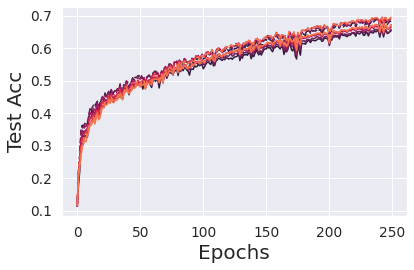

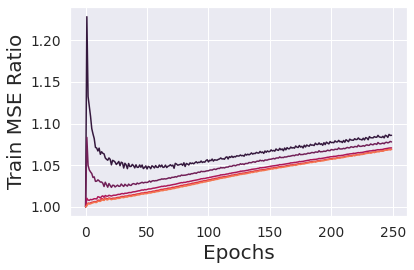

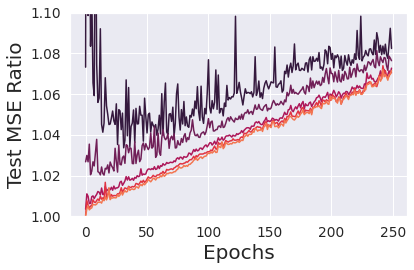

In [7]:
import seaborn as sns
sns.set(font_scale=1.25)
sns.set_style("darkgrid")
sns.set_palette("rocket")

for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_single[i][j]['train_aligns'], color = f'C{i}',label = f'$\gamma = {gamma:0.3f}$')
    if j ==0:
        plt.ylabel(r'$A(\Phi^L, y y^{\top})$',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
#plt.title(f'$N={N}$',fontsize = 20)
#plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_gamma_kernel_align_N_{Nvals[0]}_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show() 

for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_single[i][j]['train_loss'], color = f'C{i}',label = f'$\gamma = {gamma:0.3f}$')
        plt.plot(  read_ens[i][j]['train_loss'], '--', color = f'C{i}')
    if j ==0:
        plt.ylabel(r'Train Loss',fontsize =20)
        #plt.legend()
plt.xlabel(r'Epochs',fontsize = 20)
#plt.title(f'$N={N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_gamma_train_loss_N_{Nvals[0]}_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show() 


for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_single[i][j]['test_acc'], color = f'C{i}',label = f'$\gamma = {gamma:0.3f}$')
        plt.plot(  read_ens[i][j]['test_acc'], '--', color = f'C{i}')
    if j ==0:
        plt.ylabel(r'Test Acc',fontsize =20)
        #plt.legend()
plt.xlabel(r'Epochs',fontsize = 20)
#plt.title(f'$N={N}$',fontsize = 20)
#plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_gamma_test_acc_N_{Nvals[0]}_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show() 


for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_single[i][j]['train_loss'] / read_ens[i][j]['train_loss'], color = f'C{i}',label = f'$\gamma = {gamma:0.3f}$')
        #plt.plot(  read_ens[i][j]['train_loss'], '--', color = f'C{i}')
    if j ==0:
        plt.ylabel(r'Train MSE Ratio',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
#plt.title(f'$N={N}$',fontsize = 20)
#plt.legend()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_gamma_trainMSE_ratio_N_{Nvals[0]}_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show() 



for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot( read_single[i][j]['test_loss'] / read_ens[i][j]['test_loss'], color = f'C{i}',label = f'$\gamma = {gamma:0.3f}$')
        #plt.plot(  read_ens[i][j]['train_loss'], '--', color = f'C{i}')
    if j ==0:
        plt.ylabel(r'Test MSE Ratio',fontsize =20)
plt.xlabel(r'Epochs',fontsize = 20)
#plt.title(f'$N={N}$',fontsize = 20)
#plt.legend()
plt.ylim([1.0,1.1])
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_gamma_testMSE_ratio_N_{Nvals[0]}_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show() 

## Load old sweep with $\gamma \in \{0.2,0.3,0.5\}$

In [30]:
#import numpy as np
#for i, gamma in enumerate(gamma_vals):
#    for j, N in enumerate(Nvals):
#        dict_ij = all_metrics_single[i][j]
#        ens_ij = all_metrics_ens[i][j]
#        for key in dict_ij.keys():
#            path = f'results/{key}_N_{N}_gamma_{int(100*gamma)}.npy'
#            np.save(path, jnp.array(dict_ij[key]))
#            ens_path = f'results/ens_{key}_N_{N}_gamma_{int(100*gamma)}.npy'
#            np.save(ens_path, jnp.array(ens_ij[key]))

#gamma_vals = [ 0.1, 0.2 ]
#Nvals = [50, 100]

#gamma_vals = [0.01, 0.1, 0.5]
#Nvals = [128, 256]
#E = 12
#E = 6
import numpy as np
import matplotlib.pyplot as plt
#gamma_vals = [0.05, 0.1, 1.0, 2.0]
#gamma_vals = [0.1,1.0,2.0]
gamma_vals = [0.2, 0.3, 0.5]
Nvals = [32,64,128]
#Nvals = [128, 25Nvals = [64, 128]
#Nvals = [32]
batch = 256
train_size = 50000

E = 8

#loss_used = ''
loss_used = '_mse'
ens_keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns', 'train_logit_var', 'test_logit_var']
keys = ['train_loss','test_loss', 'train_acc', 'test_acc', 'aligns']

read_single =  [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
read_ens = [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
for i, gamma in enumerate(gamma_vals):
    for j, N in enumerate(Nvals):
        #dict_ij = all_metrics_single[i][j]
        for key in keys:
            #print(jnp.array(dict_ij[key]))
            path = f'results/{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}' + loss_used + '.npy'
            #os.mkdir(path)
            read_single[i][j][key] = np.load(path)
        for key in ens_keys:
            path = f'results/ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_batch_{batch}_train_size_{train_size}'+ loss_used + '.npy'
            #os.mkdir(path)
            read_ens[i][j][key] = np.load(path)

FileNotFoundError: [Errno 2] No such file or directory: 'results/train_loss_N_64_gamma_10_E_8_batch_256_train_size_50000_mse.npy'

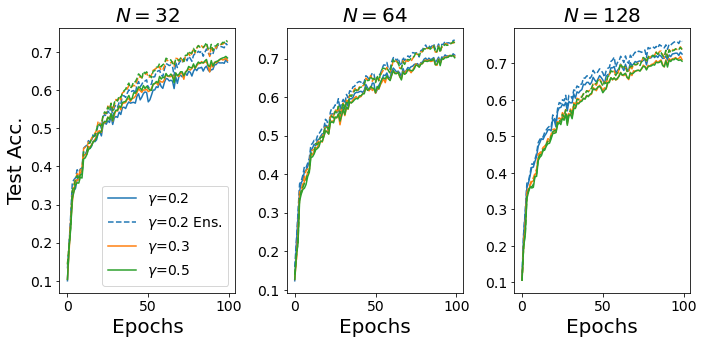

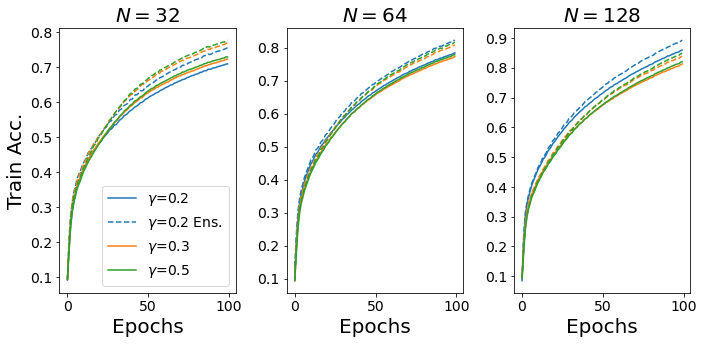

(100,)


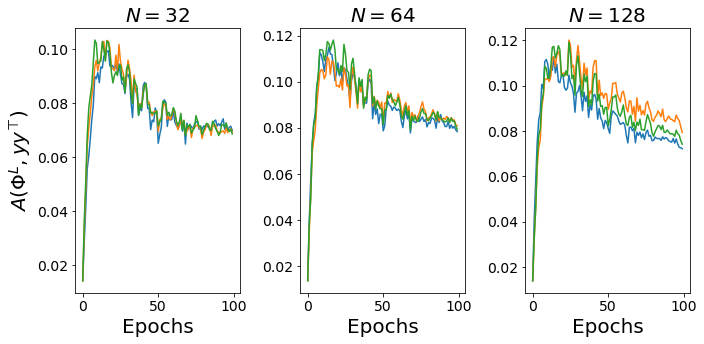

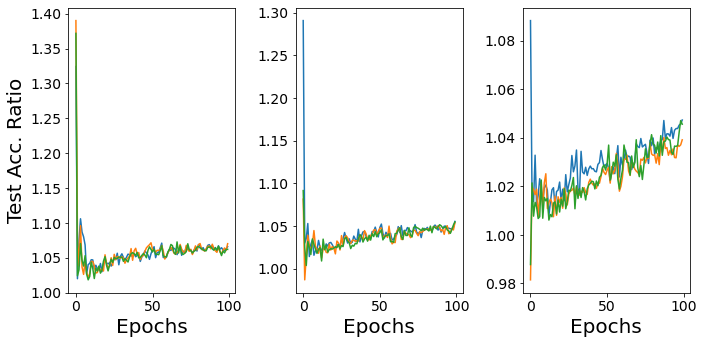

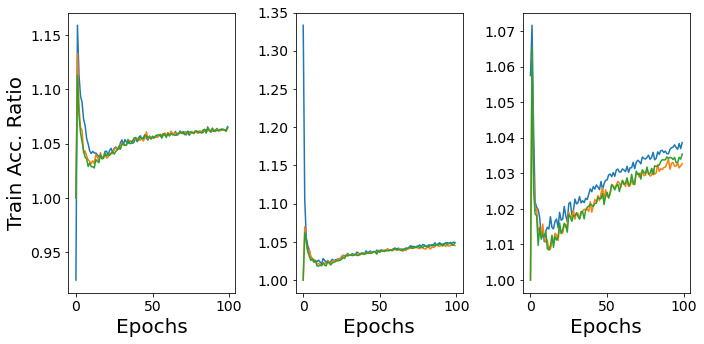

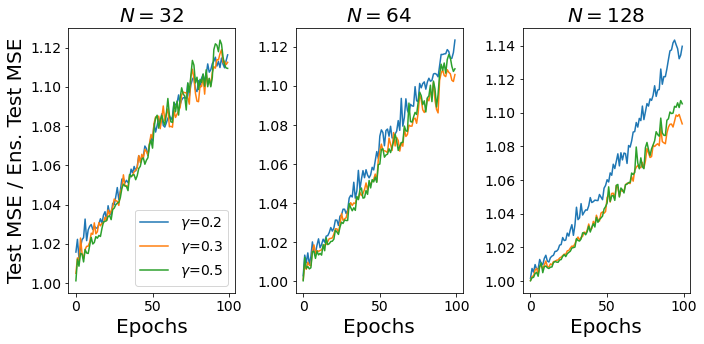

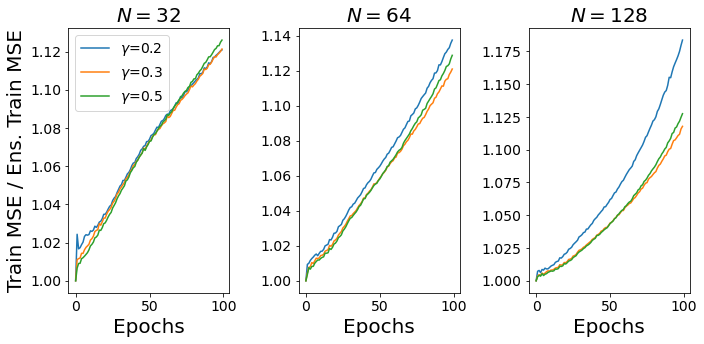

In [31]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize = (10,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        t = len( read_single[i][0]['test_acc'])
        plt.plot( read_single[i][j]['test_acc'], label = f'$\gamma$={gamma:0.1f}',color = f'C{i}')
        if j==0 and i == 0:
            plt.plot( read_ens[i][j]['test_acc'], '--', label = f'$\gamma$={gamma:0.1f} Ens.', color = f'C{i}')
        else:
            plt.plot(  read_ens[i][j]['test_acc'], '--', color = f'C{i}')
    if j ==0:
        plt.legend()
        plt.ylabel(r'Test Acc.',fontsize =20)
    plt.xlabel(r'Epochs',fontsize = 20)
    plt.title(f'$N={N}$',fontsize = 20)
    plt.tight_layout()
plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_gamma_test_accs_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()  

plt.figure(figsize = (10,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        t = len( read_single[i][0]['train_acc'])
        plt.plot(  read_single[i][j]['train_acc'], label = f'$\gamma$={gamma:0.1f}',color = f'C{i}')
        if j==0 and i == 0:
            plt.plot( read_ens[i][j]['train_acc'], '--', label = f'$\gamma$={gamma:0.1f} Ens.', color = f'C{i}')
        else:
            plt.plot(  read_ens[i][j]['train_acc'], '--', color = f'C{i}')
    if j ==0:
        plt.legend()
        plt.ylabel(r'Train Acc.',fontsize =20)
    plt.xlabel(r'Epochs',fontsize = 20)
    plt.title(f'$N={N}$',fontsize = 20)
    plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_gamma_train_accs_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()  


print(read_single[i][0]['aligns'].shape)
plt.figure(figsize = (10,5))

for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        #plt.plot(read_single[i][0]['aligns'])
        plt.plot(  read_ens[i][j]['aligns'], color = f'C{i}')
    if j ==0:
        #plt.legend()
        plt.ylabel(r'$A(\Phi^L, y y^{\top})$',fontsize =20)
    plt.xlabel(r'Epochs',fontsize = 20)
    plt.title(f'$N={N}$',fontsize = 20)
    plt.tight_layout()
plt.savefig(f'figures/full_cifar_vary_gamma_aligns_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()  

plt.figure(figsize = (10,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        plt.plot( read_ens[i][j]['test_acc'] / read_single[i][j]['test_acc'],color = f'C{i}')
        #plt.plot(read_ens[i][0]['test_acc'], '--', color = f'C{i}')
    if j ==0:
        #plt.legend()
        plt.ylabel(r'Test Acc. Ratio',fontsize =20)
    plt.xlabel(r'Epochs',fontsize = 20)
    plt.tight_layout()
#plt.ylabel(r'Ens. Acc/Single Acc.',fontsize = 20)
plt.savefig(f'figures/full_cifar_vary_gamma_test_acc_ratio_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()    


plt.figure(figsize = (10,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        plt.plot(read_ens[i][j]['train_acc'] / read_single[i][j]['train_acc'],color = f'C{i}')
        #plt.plot(read_ens[i][0]['test_acc'], '--', color = f'C{i}')
    if j ==0:
        #plt.legend()
        plt.ylabel(r'Train Acc. Ratio',fontsize =20)
    plt.xlabel(r'Epochs',fontsize = 20)
    plt.tight_layout()
#plt.ylabel(r'Ens. Acc/Single Acc.',fontsize = 20)
plt.savefig(f'figures/full_cifar_vary_gamma_train_acc_ratio_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()    


plt.figure(figsize = (10,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        plt.plot( read_single[i][j]['test_loss'] / read_ens[i][j]['test_loss'] ,color = f'C{i}', label = f'$\gamma$={gamma:0.1f}')
        #plt.plot(read_ens[i][0]['test_acc'], '--', color = f'C{i}')
    if j ==0:
        plt.legend()
        plt.ylabel(r'Test MSE / Ens. Test MSE',fontsize =20)
    plt.xlabel(r'Epochs',fontsize = 20)
    plt.title(f'$N={N}$',fontsize = 20)
    
    plt.tight_layout()
#plt.ylabel(r'Ens. Acc/Single Acc.',fontsize = 20)
plt.savefig(f'figures/full_cifar_vary_gamma_test_loss_ratio_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()    


plt.figure(figsize = (10,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    for i, gamma in enumerate(gamma_vals):
        plt.plot(read_single[i][j]['train_loss'] / read_ens[i][j]['train_loss'] , color = f'C{i}', label = f'$\gamma$={gamma:0.1f}')
        #plt.plot(read_ens[i][0]['test_acc'], '--', color = f'C{i}')
    if j ==0:
        plt.legend()
        plt.ylabel(r'Train MSE / Ens. Train MSE',fontsize =20)
    plt.xlabel(r'Epochs',fontsize = 20)
    plt.title(f'$N={N}$',fontsize = 20)
    plt.tight_layout()
#plt.ylabel(r'Ens. Acc/Single Acc.',fontsize = 20)
plt.savefig(f'figures/full_cifar_vary_gamma_train_loss_ratio_E_{E}_batch_{batch}_train_size_{train_size}.pdf')
plt.show()    




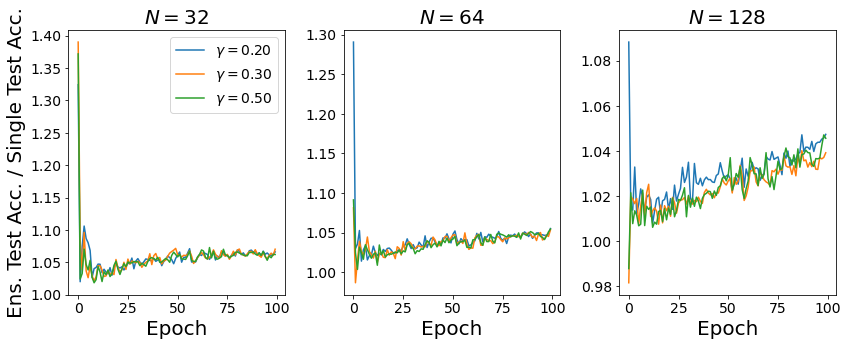

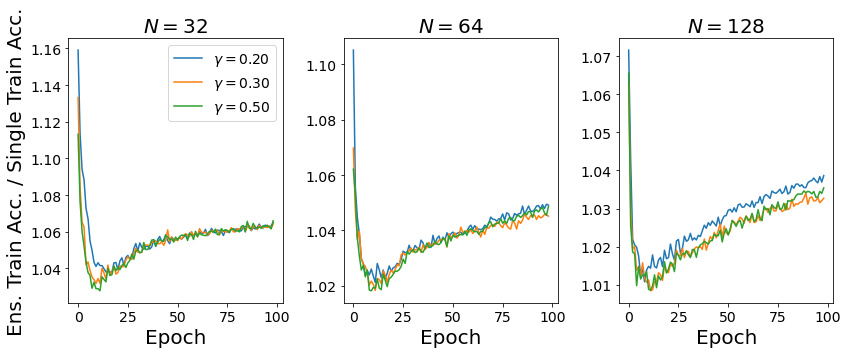

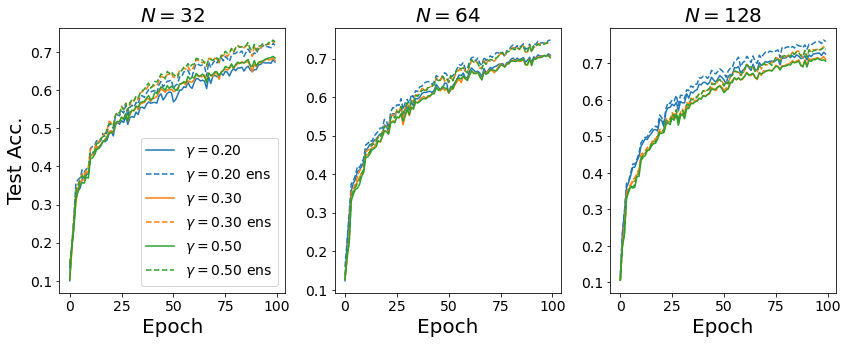

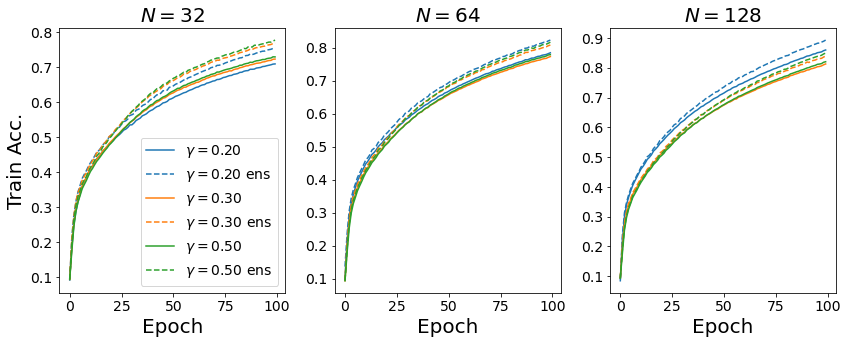

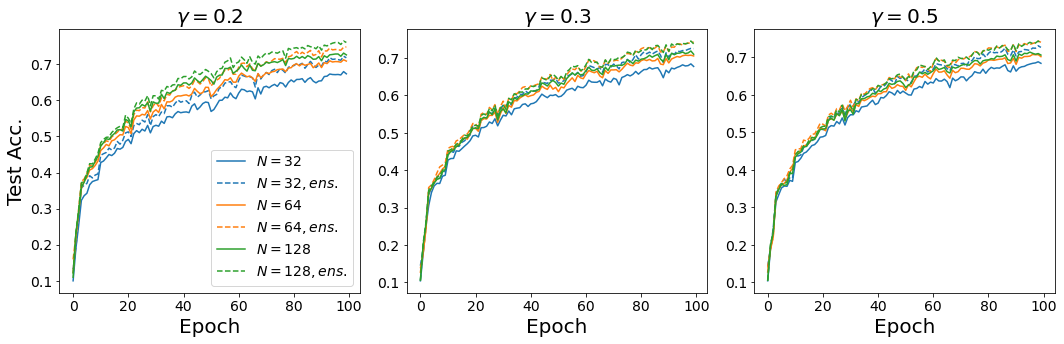

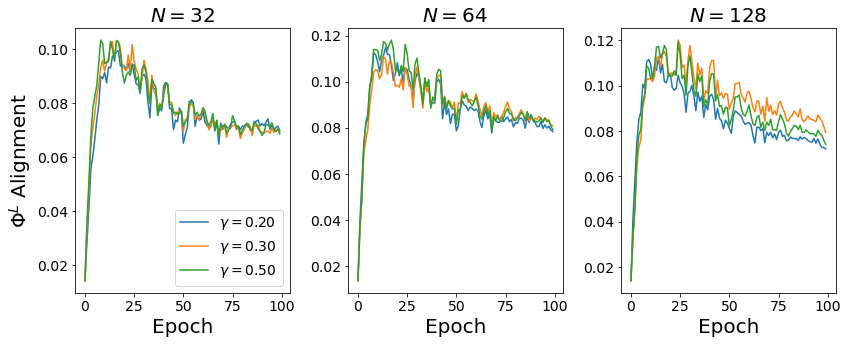

In [32]:
#Nvals=[50,100]
#gamma_vals = [0.1,0.2]
import jax.numpy as jnp  # JAX NumPy

plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (12,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    plt.title(f'$N = {N}$',fontsize =20)
    if j == 0:
        plt.ylabel('Ens. Test Acc. / Single Test Acc.',fontsize = 20)
    for i, gamma in enumerate(gamma_vals):
        plt.plot( jnp.array(read_ens[i][j]['test_acc']) / jnp.array(read_single[i][j]['test_acc']) , color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$')
        #plt.plot(jnp.array(read_ens[i][j]['train_acc']), '--', color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
    if j == 0:
        plt.legend()
    plt.xlabel(r'Epoch',fontsize = 20)
    plt.tight_layout()

#plt.savefig(f'figures/ens_ratio_test_N_panel_vary_gamma_N_cifar_E_{E}'+ loss_used + '.pdf')
plt.show()


plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (12,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    plt.title(f'$N = {N}$',fontsize =20)
    if j == 0:
        plt.ylabel('Ens. Train Acc. / Single Train Acc.',fontsize = 20)
    for i, gamma in enumerate(gamma_vals):
        plt.plot( jnp.array(read_ens[i][j]['train_acc'])[1:] / jnp.array(read_single[i][j]['train_acc'])[1:] , color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$')
        #plt.plot(jnp.array(read_ens[i][j]['train_acc']), '--', color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
    if j == 0:
        plt.legend()
    plt.xlabel(r'Epoch',fontsize = 20)
    plt.tight_layout()

#plt.savefig(f'figures/ens_ratio_train_N_panel_vary_gamma_N_cifar_E_{E}_mse.pdf')
plt.show()

plt.figure(figsize = (12,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    plt.title(f'$N = {N}$',fontsize =20)
    if j == 0:
        plt.ylabel('Test Acc.',fontsize = 20)
    for i, gamma in enumerate(gamma_vals):
        plt.plot( jnp.array(read_single[i][j]['test_acc']) , color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$')
        plt.plot(jnp.array(read_ens[i][j]['test_acc']), '--', color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$ ens')
    if j == 0:
        plt.legend()
    plt.xlabel(r'Epoch',fontsize = 20)
    plt.tight_layout()

#plt.savefig(f'figures/test_acc_N_panel_vary_gamma_N_cifar_E_{E}.pdf')
plt.show()

plt.figure(figsize = (12,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    plt.title(f'$N = {N}$',fontsize =20)
    if j == 0:
        plt.ylabel('Train Acc.',fontsize = 20)
    for i, gamma in enumerate(gamma_vals):
        plt.plot( jnp.array(read_single[i][j]['train_acc']) , color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$')
        plt.plot(jnp.array(read_ens[i][j]['train_acc']), '--', color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$ ens')
    if j == 0:
        plt.legend()
    plt.xlabel(r'Epoch',fontsize = 20)
    plt.tight_layout()
#plt.savefig(f'figures/train_acc_N_panel_vary_gamma_N_cifar_E_{E}.pdf')
plt.show()

plt.figure(figsize = (15,5))
for i, gamma in enumerate(gamma_vals):
    plt.subplot(1, len(gamma_vals), i+1)
    plt.title(f'$\gamma = {gamma:0.1f}$',fontsize =20)
    if i == 0:
        plt.ylabel('Test Acc.',fontsize = 20)
    for j, N in enumerate(Nvals):
        plt.plot( jnp.array(read_single[i][j]['test_acc']), color = f'C{j}', label = f'$N = {N}$')
        plt.plot(jnp.array(read_ens[i][j]['test_acc']), '--', color = f'C{j}', label = f'$N = {N} , ens.$')
    if i == 0:
        plt.legend()
    plt.xlabel(r'Epoch',fontsize = 20)
    plt.tight_layout()
#plt.savefig(f'figures/test_acc_gamma_panel_vary_gamma_N_cifar_E_{E}.pdf')
plt.show()




plt.figure(figsize = (12,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    plt.title(f'$N = {N}$',fontsize =20)
    if j == 0:
        plt.ylabel(r'$\Phi^L$ Alignment',fontsize = 20)
    for i, gamma in enumerate(gamma_vals):
        plt.plot( jnp.array(read_single[i][j]['aligns']) , color = f'C{i}', label = f'$\gamma = {gamma:0.2f}$')
        #plt.plot( jnp.array(read_ens[i][j]['aligns'])  , '--', color = f'C{j}', label = f'$N = {N} , ens.$')
    if j == 0:
        plt.legend()
    plt.xlabel(r'Epoch',fontsize = 20)
    plt.tight_layout()
#plt.savefig(f'figures/aligns_vary_gamma_N_cifar_E_{E}.pdf')
plt.show()






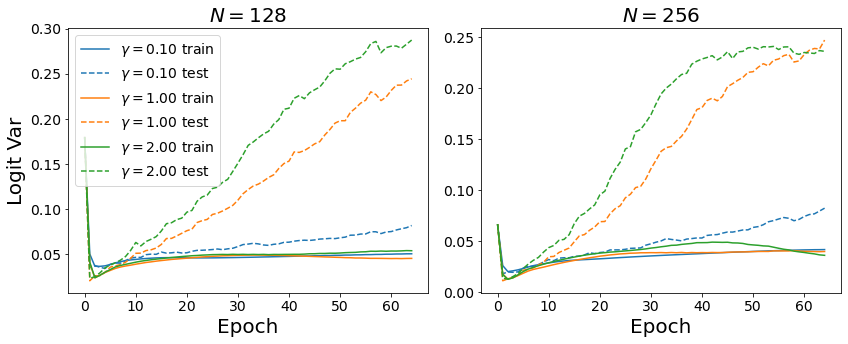

In [25]:

plt.figure(figsize = (12,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    plt.title(f'$N = {N}$',fontsize =20)
    if j == 0:
        plt.ylabel(r'Logit Var',fontsize = 20)
    for i, gamma in enumerate(gamma_vals):

        plt.plot( jnp.array(read_ens[i][j]['train_logit_var']) , color = f'C{i}', label = f'$\gamma = {gamma:0.2f}$ train')
        plt.plot( jnp.array(read_ens[i][j]['test_logit_var']) , '--', color = f'C{i}', label = f'$\gamma = {gamma:0.2f}$ test')
    if j == 0:
        plt.legend()
    plt.xlabel(r'Epoch',fontsize = 20)
    plt.tight_layout()
#plt.savefig(f'figures/train_logit_var_vary_gamma_N_cifar_E_{E}.pdf')
plt.show()

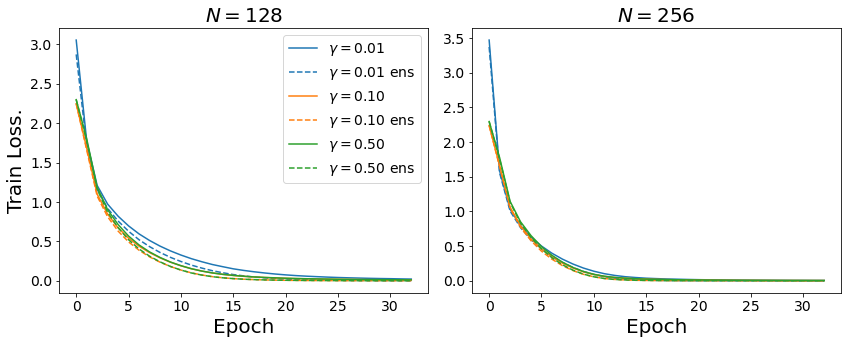

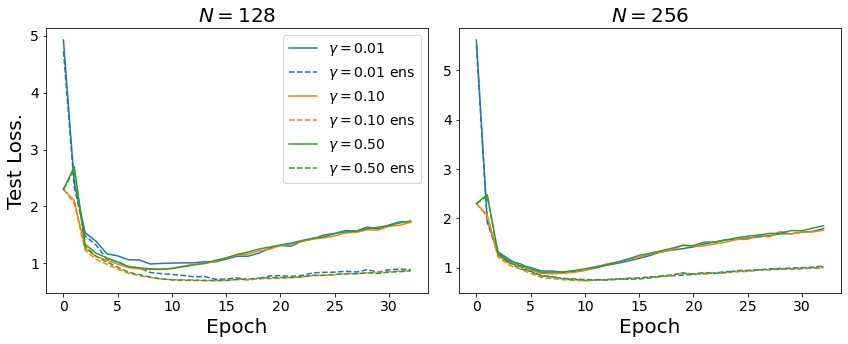

In [28]:

plt.figure(figsize = (12,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    plt.title(f'$N = {N}$',fontsize =20)
    if j == 0:
        plt.ylabel('Train Loss.',fontsize = 20)
    for i, gamma in enumerate(gamma_vals):
        plt.plot( jnp.array(read_single[i][j]['train_loss']) , color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$')
        plt.plot(jnp.array(read_ens[i][j]['train_loss']), '--', color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$ ens')
    if j == 0:
        plt.legend()
    plt.xlabel(r'Epoch',fontsize = 20)
    plt.tight_layout()
#plt.savefig(f'figures/train_acc_N_panel_vary_gamma_N_cifar_E_{E}.pdf')
plt.show()


plt.figure(figsize = (12,5))
for j, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), j+1)
    plt.title(f'$N = {N}$',fontsize =20)
    if j == 0:
        plt.ylabel('Test Loss.',fontsize = 20)
    for i, gamma in enumerate(gamma_vals):
        plt.plot( jnp.array(read_single[i][j]['test_loss']) , color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$')
        plt.plot(jnp.array(read_ens[i][j]['test_loss']), '--', color = f'C{i}', label = f'$\gamma = {gamma : 0.2f}$ ens')
    if j == 0:
        plt.legend()
    plt.xlabel(r'Epoch',fontsize = 20)
    plt.tight_layout()
#plt.savefig(f'figures/train_acc_N_panel_vary_gamma_N_cifar_E_{E}.pdf')
plt.show()

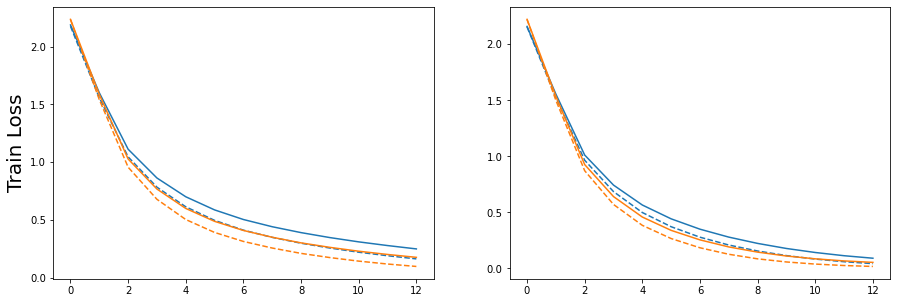

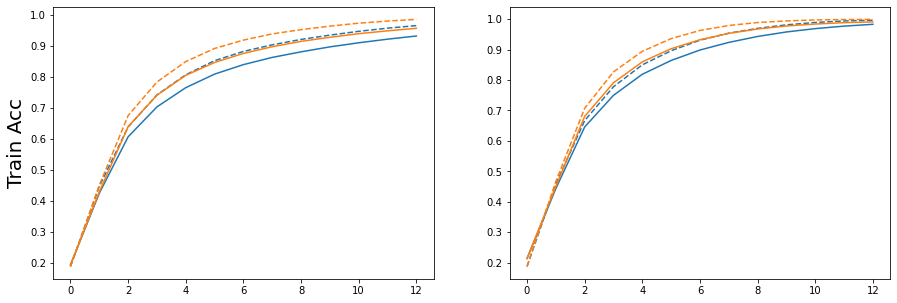

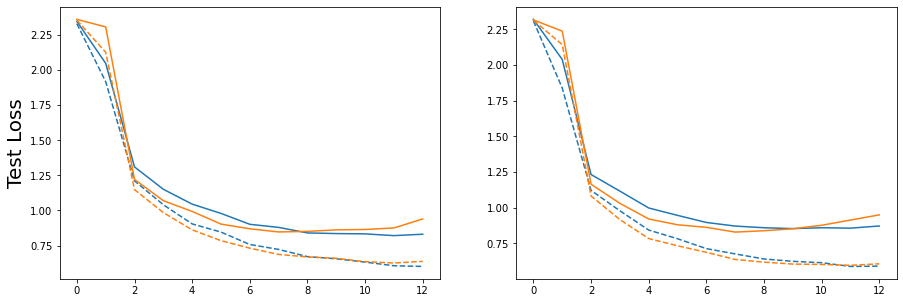

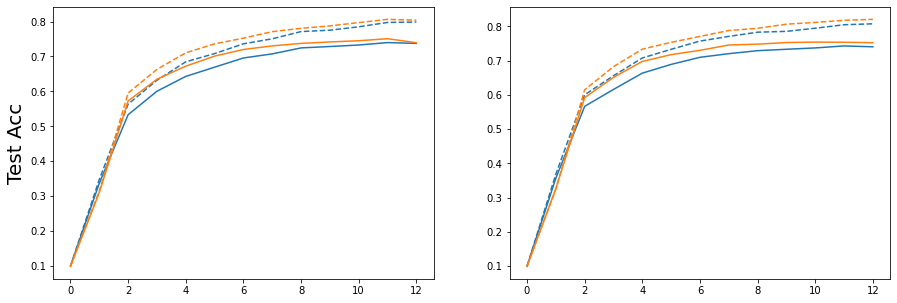

In [42]:
plt.figure(figsize = (15,5))
for i, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), i+1)
    if i == 0:
        plt.ylabel('Train Loss',fontsize = 20)
    for j, gamma in enumerate(gamma_vals):
        plt.plot(jnp.array(read_single[j][i]['train_loss']), color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
        plt.plot(jnp.array(read_ens[j][i]['train_loss']), '--', color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
plt.show()

plt.figure(figsize = (15,5))
for i, N in enumerate(Nvals):
    plt.subplot(1, len(Nvals), i+1)
    if i == 0:
        plt.ylabel('Train Acc',fontsize = 20)
    for j, gamma in enumerate(gamma_vals):
        plt.plot(jnp.array(read_single[j][i]['train_acc']), color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
        plt.plot(jnp.array(read_ens[j][i]['train_acc']), '--', color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
plt.show()



plt.figure(figsize = (15,5))
for i, gamma in enumerate(gamma_vals):
    plt.subplot(1, len(gamma_vals), i+1)
    if i == 0:
        plt.ylabel('Test Loss',fontsize = 20)
    for j, N in enumerate(Nvals):
        plt.plot(jnp.array(read_single[i][j]['test_loss']), color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
        plt.plot(jnp.array(read_ens[i][j]['test_loss']), '--', color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
plt.show()


plt.figure(figsize = (15,5))
for i, gamma in enumerate(gamma_vals):
    plt.subplot(1, len(gamma_vals), i+1)
    if i == 0:
        plt.ylabel('Test Acc',fontsize = 20)
    for j, N in enumerate(Nvals):
        plt.plot(jnp.array(read_single[i][j]['test_acc']), color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
        plt.plot(jnp.array(read_ens[i][j]['test_acc']), '--', color = f'C{j}', label = f'$\gamma = {gamma : 0.3f}$')
plt.show()

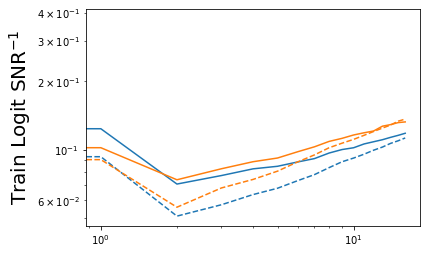

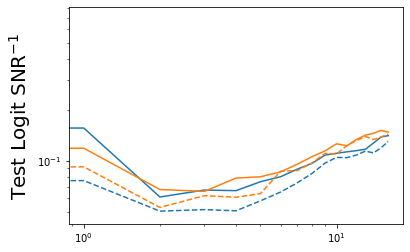

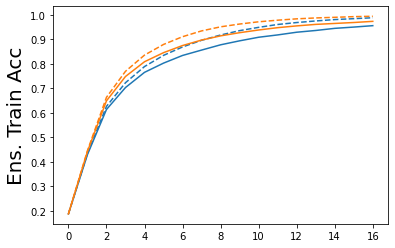

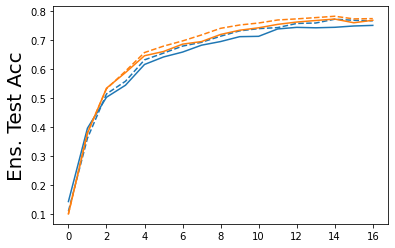

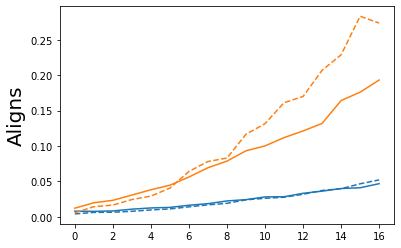

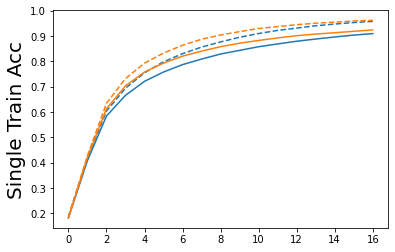

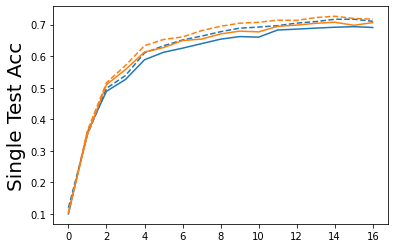

In [276]:
for i, gamma in enumerate(gamma_vals):
    plt.loglog(jnp.array(all_metrics_ens[i][0]['train_logit_var']), color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
    plt.loglog(jnp.array(all_metrics_ens[i][1]['train_logit_var']), '--', color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
plt.ylabel('Train Logit SNR$^{-1}$',fontsize = 20)
plt.show()

for i, gamma in enumerate(gamma_vals):
    plt.loglog(jnp.array(all_metrics_ens[i][0]['test_logit_var']), color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
    plt.loglog(jnp.array(all_metrics_ens[i][1]['test_logit_var']), '--', color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
plt.ylabel('Test Logit SNR$^{-1}$',fontsize = 20)
plt.show()


for i, gamma in enumerate(gamma_vals):
    plt.plot(jnp.array(all_metrics_ens[i][0]['train_acc']), color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
    plt.plot(jnp.array(all_metrics_ens[i][1]['train_acc']), '--', color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
plt.ylabel('Ens. Train Acc',fontsize = 20)
plt.show()

for i, gamma in enumerate(gamma_vals):
    plt.plot(all_metrics_ens[i][0]['test_acc'], color = f'C{i}')
    plt.plot(all_metrics_ens[i][1]['test_acc'], '--', color = f'C{i}')
plt.ylabel('Ens. Test Acc',fontsize = 20)
plt.show()


for i, gamma in enumerate(gamma_vals):
    plt.plot(jnp.array(all_metrics_ens[i][0]['aligns']), color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
    plt.plot(0.5*jnp.array(all_metrics_ens[i][1]['aligns']), '--', color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
plt.ylabel('Aligns',fontsize = 20)
plt.show()

for i, gamma in enumerate(gamma_vals):
    plt.plot(jnp.array(all_metrics_single[i][0]['train_acc']), color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
    plt.plot(jnp.array(all_metrics_single[i][1]['train_acc']), '--', color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
plt.ylabel('Single Train Acc',fontsize = 20)
plt.show()

for i, gamma in enumerate(gamma_vals):
    plt.plot(all_metrics_single[i][0]['test_acc'], color = f'C{i}')
    plt.plot(all_metrics_single[i][1]['test_acc'], '--', color = f'C{i}')
plt.ylabel('Single Test Acc',fontsize = 20)
plt.show()



In [158]:
len( all_metrics_single[0][0] )

4

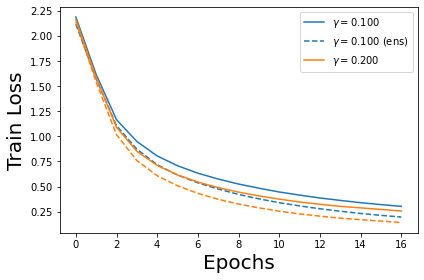

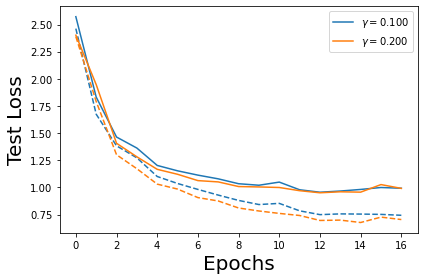

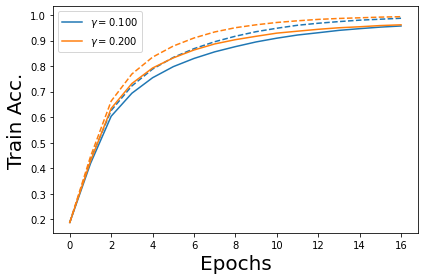

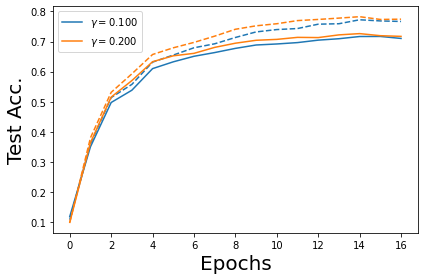

TypeError: list indices must be integers or slices, not str

In [271]:
for i, gamma in enumerate(gamma_vals):
  plt.plot(all_metrics_single[i][0]['train_loss'], color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
  if i == 0:
    plt.plot(all_metrics_ens[i][0]['train_loss'], '--',label = f'$\gamma = {gamma : 0.3f}$ (ens)', color = f'C{i}')
  else:
    plt.plot(all_metrics_ens[i][0]['train_loss'], '--', color = f'C{i}')

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r'Train Loss',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()

for i, gamma in enumerate(gamma_vals):
  plt.plot(all_metrics_single[i][0]['test_loss'], color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
  plt.plot(all_metrics_ens[i][0]['test_loss'], '--', color = f'C{i}')
plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r'Test Loss',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()

for i, gamma in enumerate(gamma_vals):
  plt.plot(all_metrics_single[i][1]['train_acc'], color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
  plt.plot(all_metrics_ens[i][1]['train_acc'], '--', color = f'C{i}')
plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r'Train Acc.',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()

for i, gamma in enumerate(gamma_vals):
  plt.plot(all_metrics_single[i][1]['test_acc'], color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
  plt.plot(all_metrics_ens[i][1]['test_acc'], '--', color = f'C{i}')
plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r'Test Acc.',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()

for i, gamma in enumerate(gamma_vals):
  plt.plot(all_metrics_ens[i]['test_logit_var'], color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
  #plt.plot(all_metrics_ens[i]['test_logit_var'], '--', color = f'C{i}')
plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r'Test Logit Variance',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/cifar_test_logit_var_N_{N}_myrtle7.pdf')
plt.show()


for i, gamma in enumerate(gamma_vals):
  plt.plot(all_metrics_ens[i]['train_logit_var'], color = f'C{i}', label = f'$\gamma = {gamma : 0.3f}$')
  #plt.plot(all_metrics_ens[i]['test_logit_var'], '--', color = f'C{i}')
plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r'Train Logit Variance',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/cifar_train_logit_var_N_{N}_myrtle7.pdf')
plt.show()


In [311]:
#import json
#with open(f'results/N_{Nvals[0]}_{Nvals[1]}_metrics_single', 'w') as fout:
#    json.dump(all_metrics_single, fout)
#with open(f'results/N_{N}_metrics_ens', 'w') as fout:
#    json.dump(all_metrics_ens, fout)
import os 


[2.1859717  1.6137142  1.1650295  0.94863    0.8050842  0.70738137
 0.6335474  0.5756825  0.52575904 0.4844908  0.44662377 0.41594127
 0.38723126 0.36310503 0.3405735  0.3213299  0.30401194]
[2.5724037  1.8319976  1.4638518  1.3623203  1.2022469  1.1526675
 1.1129465  1.0787351  1.0337147  1.0198357  1.0487307  0.978089
 0.9554675  0.9664166  0.98108137 0.9990062  0.9920585 ]
[0.18229167 0.40845406 0.58398354 0.6657631  0.72097075 0.75768244
 0.7868418  0.8086354  0.82873195 0.84300977 0.85738766 0.8684312
 0.8790647  0.88774407 0.8958333  0.9033024  0.90909094]
[0.10029381 0.35925817 0.48854837 0.52595824 0.5883581  0.61206263
 0.6250835  0.63947314 0.6535624  0.6617755  0.6599559  0.682659
 0.6852798  0.6885684  0.69137293 0.6930923  0.690605  ]
[0.0080046  0.00775733 0.00832856 0.01079987 0.01257034 0.01334567
 0.01637663 0.01860034 0.02244714 0.02430012 0.02814776 0.02837889
 0.03323695 0.03628207 0.03998132 0.04107258 0.04684275]
[2.110005   1.5951514  1.1126255  0.8781248  0.7204

In [317]:
print(read_dict[0][0])

{'train_loss': array([2.1859717 , 1.6137142 , 1.1650295 , 0.94863   , 0.8050842 ,
       0.70738137, 0.6335474 , 0.5756825 , 0.52575904, 0.4844908 ,
       0.44662377, 0.41594127, 0.38723126, 0.36310503, 0.3405735 ,
       0.3213299 , 0.30401194], dtype=float32), 'test_loss': array([2.5724037 , 1.8319976 , 1.4638518 , 1.3623203 , 1.2022469 ,
       1.1526675 , 1.1129465 , 1.0787351 , 1.0337147 , 1.0198357 ,
       1.0487307 , 0.978089  , 0.9554675 , 0.9664166 , 0.98108137,
       0.9990062 , 0.9920585 ], dtype=float32), 'train_acc': array([0.18229167, 0.40845406, 0.58398354, 0.6657631 , 0.72097075,
       0.75768244, 0.7868418 , 0.8086354 , 0.82873195, 0.84300977,
       0.85738766, 0.8684312 , 0.8790647 , 0.88774407, 0.8958333 ,
       0.9033024 , 0.90909094], dtype=float32), 'test_acc': array([0.10029381, 0.35925817, 0.48854837, 0.52595824, 0.5883581 ,
       0.61206263, 0.6250835 , 0.63947314, 0.6535624 , 0.6617755 ,
       0.6599559 , 0.682659  , 0.6852798 , 0.6885684 , 0.69137293,

In [283]:
from flax import serialization
bytes_output = serialization.to_bytes(all_metrics_single)
#dict_output = serialization.to_state_dict(all_metrics_ens)

with open("/results/single.bin", "wb") as bf:
  bf.write(bytes_output)

AttributeError: module 'jax' has no attribute 'Array'

In [131]:
from jax.example_libraries import optimizers

def get_k_err_alignment(states, kernel_fns, Xbt, ybt):
    all_aligns = []
    P = ybt.shape[0]
    #K_avg = jnp.zeros((P,P,10,10))
    #Delta_avg = jnp.zeros((P, 10))
    y_hot = nn.one_hot(ybt, 10)
    y_hot -= 0.1 * jnp.ones(y_hot.shape)
    projs = []
    for e, state in enumerate(states):
        
        #kernel_fn = kernel_fns[e]
        #K = kernel_fn(Xbt, Xbt, 'ntk', state.params)
        
        Delta = y_hot -  state.apply_fn({'params': state.params}, Xbt)
        #Delta_avg += 1/len(states) * Delta
        #K_avg += 1/len(states) * K
        grad_Delta = kernel_fns[e](state.params, Xbt, Delta)
        projs += [ optimizers.l2_norm(grad_Delta)**2 / jnp.sum(Delta**2) ]
    #K_norm = jnp.sqrt( jnp.sum( K_avg**2 ) )
    #proj = jnp.einsum('ik,ik', jnp.einsum('ijkl,jl->ik', K_avg, Delta_avg), Delta_avg) / jnp.sum(Delta_avg**2)
    return jnp.mean( jnp.array(projs) )

def train_full_batch_track_K(states, kernel_fns, num_steps=100, train_size = 512):
  
  if train_size >= 50000:
    train_size = X.shape[0]
    
  Xtr = X[0:train_size]
  ytr = y[0:train_size]
  batch_size = train_size

  metrics_single = {'train_loss': [], 'train_acc': []}
  metrics_ens = {'train_loss': [], 'train_acc': [], 'train_logit_var': [], 'train_k_err_aligns': [], 'knorm': []}

  E = len(states)
  for step in range(num_steps):
    
    if step == 0:
        print(ytr[0:5])
    # compute train and ens train loss  
    
    
    for e, state in enumerate(states):
      # Run optimization steps over training batches and compute batch metrics
      states[e] = train_step(state, Xtr, ytr)
    if step % 25 == 0:
        losses, ens_loss, acc, ens_acc, var_logits = get_all_metrics(states, Xtr, ytr)
        err_align = get_k_err_alignment(states, kernel_fns, Xtr, ytr)        
        metrics_single['train_loss'].append( jnp.array(losses).mean() )
        metrics_single['train_acc'].append( jnp.array(acc).mean()   )
        metrics_ens['train_loss'].append( ens_loss )
        metrics_ens['train_acc'].append( ens_acc )
        metrics_ens['train_logit_var'].append( var_logits )
        metrics_ens['train_k_err_aligns'].append( err_align )
        #metrics_ens['knorm'].append(Knorm)
        print(f"step = {step}, train = {metrics_single['train_loss'][-1]:0.3f}, ens train = {metrics_ens['train_loss'][-1]:0.3f}, aligns = {metrics_ens['train_k_err_aligns'][-1]:0.3f}")
  return metrics_single, metrics_ens

In [132]:
gamma = 0.05
base_lr = 0.1
#train_size = 64
train_size = 128
Nvals = [32,64,128,256]
E = 10
num_steps = 8000

ens_keys = ['train_loss', 'train_acc', 'train_k_err_aligns', 'knorm']
keys = ['train_loss', 'train_acc']

init_rng_list = [ jax.random.PRNGKey(e) for e in range(E)]

for i, N in enumerate(Nvals):
    cnn = CNN(width = N)
    print(cnn.width)
    states = [ create_train_state(cnn, init_rng, cnn.width * gamma**(0.5) * base_lr, momentum = 0.0, gamma = gamma) for init_rng in init_rng_list ]
    #kernel_fn = jax.jit( nt.empirical_kernel_fn(lambda params,X: states[0].apply_fn({'params':params},X), trace_axes=(), vmap_axes= 0), static_argnums=(2))

    kernel_fns = [ jax.jit(jax.grad(lambda params,X,Delta: jnp.sum( state.apply_fn({'params':params},X) * Delta) ,0)) for state in states  ]
    #kernel_fns = [ nt.empirical_kernel_fn(lambda params,X: state.apply_fn({'params':params},X), trace_axes=(), vmap_axes= 0) for state in states ]
    metrics_single, metrics_ens = train_full_batch_track_K(states, kernel_fns ,train_size = train_size,  num_steps = num_steps)
    
    for key in keys:
        path = f'results/avg_align_expt_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_train_size_{train_size}_mse.npy'
        np.save(path, jnp.array(metrics_single[key]))
    for key in ens_keys:
        ens_path = f'results/avg_align_expt_ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_train_size_{train_size}_mse.npy'
        np.save(ens_path, jnp.array(metrics_ens[key]))
    

32
[7 8 4 4 6]
step = 0, train = 0.045, ens train = 0.045, aligns = 2.483
step = 25, train = 0.044, ens train = 0.044, aligns = 0.304
step = 50, train = 0.044, ens train = 0.044, aligns = 0.243
step = 75, train = 0.043, ens train = 0.043, aligns = 0.211
step = 100, train = 0.043, ens train = 0.043, aligns = 0.189
step = 125, train = 0.043, ens train = 0.043, aligns = 0.173
step = 150, train = 0.043, ens train = 0.043, aligns = 0.159
step = 175, train = 0.043, ens train = 0.042, aligns = 0.149
step = 200, train = 0.042, ens train = 0.042, aligns = 0.140
step = 225, train = 0.042, ens train = 0.042, aligns = 0.131
step = 250, train = 0.042, ens train = 0.042, aligns = 0.124
step = 275, train = 0.042, ens train = 0.042, aligns = 0.117
step = 300, train = 0.042, ens train = 0.042, aligns = 0.112
step = 325, train = 0.042, ens train = 0.041, aligns = 0.107
step = 350, train = 0.042, ens train = 0.041, aligns = 0.102
step = 375, train = 0.041, ens train = 0.041, aligns = 0.098
step = 400, tr

KeyboardInterrupt: 

In [33]:
gamma_vals = [0.05]
Nvals = [32,64,128,256, 512]
train_size = 64
E = 10

#Nvals = [32,64,128,256]
#train_size = 128
ens_keys = ['train_loss', 'train_acc', 'train_k_err_aligns', 'knorm']
keys = ['train_loss', 'train_acc']

read_single =  [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
read_ens = [ [ {} for j in range(len(Nvals))] for i in range(len(gamma_vals))  ]
for i, gamma in enumerate(gamma_vals):
    for j, N in enumerate(Nvals):
        #dict_ij = all_metrics_single[i][j]
        for key in keys:
            #print(jnp.array(dict_ij[key]))
            path = f'results/avg_align_expt_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_train_size_{train_size}_mse.npy'
            #os.mkdir(path)
            read_single[i][j][key] = np.load(path)
        for key in ens_keys:
            path = f'results/avg_align_expt_ens_{key}_N_{N}_gamma_{int(100*gamma)}_E_{E}_train_size_{train_size}_mse.npy'
            #os.mkdir(path)
            read_ens[i][j][key] = np.load(path)

-0.0017133477
-0.0024832853
-0.0029617317
-0.003297154
-0.003422132


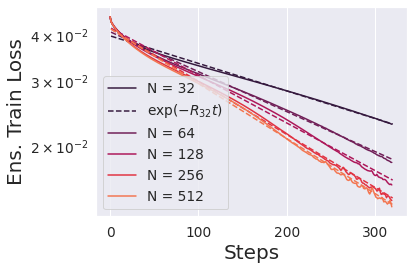

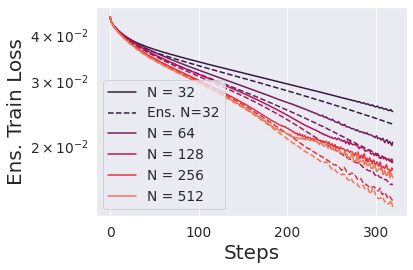

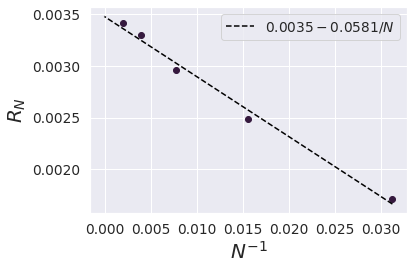

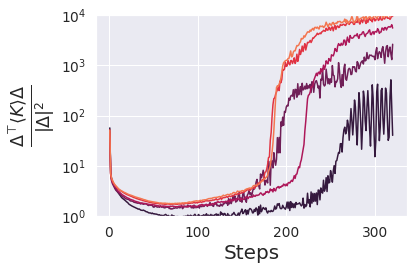

In [35]:
#plt.rcParams.update({'font.size': 14})
import seaborn as sns
import jax.numpy as jnp
sns.set(font_scale=1.25)
sns.set_style("darkgrid")
sns.set_palette("rocket")

exponents = []
for i, N in enumerate(Nvals):
    #plt.semilogy(read_single[0][i]['train_loss'], color = f'C{i}', label = f'N = {N}')
    plt.semilogy(read_ens[0][i]['train_loss'], color = f'C{i}', label = f'N = {N}')
    yl = jnp.log(read_ens[0][i]['train_loss'])
    x = jnp.linspace(1,len(yl),len(yl))
    exponent = (jnp.mean(x*yl) - jnp.mean(x)*jnp.mean(yl))/ jnp.var(x)
    b = jnp.mean(yl) - exponent*jnp.mean(x)
    print(exponent)
    exponents += [exponent]
    if i == 0:
        plt.semilogy(x, jnp.exp(x * exponent + b), '--', color = f'C{i}', label = r'$\exp(- R_{%d} t)$' % N)
    else:
        plt.semilogy(x, jnp.exp(x * exponent + b), '--', color = f'C{i}')
plt.xlabel(r'Steps', fontsize = 20)
plt.ylabel(r'Ens. Train Loss', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/avg_align_expt_train_loss.pdf')
plt.show()

for i, N in enumerate(Nvals):
    plt.semilogy(read_single[0][i]['train_loss'], color = f'C{i}', label = f'N = {N}')
    if i ==0:
        plt.semilogy(read_ens[0][i]['train_loss'], '--', color = f'C{i}', label = f'Ens. N={N}')
    else:
        plt.semilogy(read_ens[0][i]['train_loss'], '--', color = f'C{i}')
    #yl = jnp.log(read_ens[0][i]['train_loss'])
    #x = jnp.linspace(1,len(yl),len(yl))
    #exponent = (jnp.mean(x*yl) - jnp.mean(x)*jnp.mean(yl))/ jnp.var(x)
    #b = jnp.mean(yl) - exponent*jnp.mean(x)
    #print(exponent)
    #exponents += [exponent]
    #if i == 0:
    #    plt.semilogy(x, jnp.exp(x * exponent + b), '--', color = f'C{i}', label = r'$\exp(- R_{%d} t)$' % N)
    #else:
    #    plt.semilogy(x, jnp.exp(x * exponent + b), '--', color = f'C{i}')
plt.xlabel(r'Steps', fontsize = 20)
plt.ylabel(r'Ens. Train Loss', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/avg_align_expt_train_loss_single_vs_ens.pdf')
plt.show()

x = jnp.array(Nvals)**(-1.0)
yl = -jnp.array(exponents)
exponent_exponent = (jnp.mean(x*yl) - jnp.mean(x)*jnp.mean(yl))/ jnp.var(x)
b = jnp.mean(yl) - exponent_exponent*jnp.mean(x)
#plt.semilogx(jnp.array(Nvals)**(-1.0), 1.0-1.0/jnp.array(Nvals) )
plt.scatter(jnp.array(Nvals)**(-1.0), -jnp.array(exponents))
N_cont = jnp.logspace(jnp.log10(32),10.0,100)
plt.plot(jnp.array(N_cont)**(-1.0), b + exponent_exponent*jnp.array(N_cont)**(-1.0), '--', color = 'black', label = f'${b:0.4f}  {exponent_exponent:0.4f}/N$')
plt.xlabel(r'$N^{-1}$',fontsize = 20)
plt.ylabel(r'$R_{N}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/avg_align_expt_rate_trends.pdf')
plt.show()

for i, N in enumerate(Nvals):
    T = len( read_ens[0][i]['train_k_err_aligns'] )
    plt.semilogy(jnp.linspace(1,T,T), N*read_ens[0][i]['train_k_err_aligns'])
plt.ylabel(r'$\frac{\Delta^\top \left< K \right> \Delta}{|\Delta|^2}$',fontsize = 25)
plt.xlabel(r'Steps', fontsize = 20)
plt.ylim([1e0,1e4])
plt.tight_layout()
plt.savefig('figures/avg_align_expt_raleigh_quotient.pdf')
plt.show()

In [86]:
kernel_fn = jax.jit(kernel_fn, static_argnums = (2))

In [89]:
K = kernel_fn(X[0:356], X[0:356], 'ntk' ,state.params)


In [90]:
print(K.shape)

(356, 356, 10, 10)
